In [1]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

def calculate_metrics(true_values, pred_values):
    mse = round(mean_squared_error(true_values, pred_values),3)
    mae = round(mean_absolute_error(true_values, pred_values),3)
    r_score = round(r2_score(true_values, pred_values),3)

    return {"mse": mse,
            "mae": mae,
            "r^2": r_score,}

In [2]:
import h2o
from h2o.automl import H2OAutoML

# Start the H2O cluster (locally)
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,3 hours 47 mins
H2O_cluster_timezone:,Europe/Kiev
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.3
H2O_cluster_version_age:,1 month and 19 days
H2O_cluster_name:,H2O_from_python_38066_h97mcq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2.749 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [6]:
import os
import sys
sys.path.insert(0, os.path.dirname('C:\work\DrugDiscovery\main_git\XAI_Chem\ml_part'))

import pandas as pd

from ml_part.random_forest.data_prep.preparation import DataPreparation
from ml_part.random_forest.train import RFTrain

CSV_PATH = r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\remained_features_pKa_08.02_v4_fixed_distances_chirality.csv'
smiles_filepath = r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\smiles_to_index.pkl'

dataPreparation = DataPreparation(CSV_PATH)

unimportant_features_to_drop = ['dipole_moment']
X, y = dataPreparation.prepare_data_for_RF(is_pKa=True,
                                           use_mandatory_features=True,
                                           is_remove_outliers=True,
                                           is_remove_nan=False,
                                           outliers_features_to_skip=unimportant_features_to_drop)

correlated_features = ['f_atom_fraction', 'naHRing', 'nFaRing', 'nFaHRing', 'tpsa+f']
ring_features_to_remain = ['nFRing', 'nHRing', 'nARing', 'nFHRing']
features_to_drop = []
for feature_name in X.columns:
    if feature_name in correlated_features:
        features_to_drop.append(feature_name)
    elif "ring" in feature_name.lower() and feature_name not in ring_features_to_remain:
        features_to_drop.append(feature_name)
    elif len(X[feature_name].unique()) == 1:
        print(f"feature without unique values: {feature_name}")
        features_to_drop.append(feature_name)
    elif "angle" in feature_name or "distance" in feature_name:
        features_to_drop.append(feature_name)

X = X.drop(features_to_drop, axis=1)

rf_train = RFTrain(X=X, 
                   y=y,
                   smiles_filepath=smiles_filepath,
                   is_pKa=True,
                   k_folds=2)

y_train = rf_train.y_train
X_train = rf_train.X_train

y_test = rf_train.y_test
X_test = rf_train.X_test

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

print(len(train_df), len(test_df))

train = h2o.H2OFrame(train_df)
test = h2o.H2OFrame(test_df)

True
183
['RPCS', 'PBF', 'mol_weight', 'dipole_moment', 'PPSA5', 'avg_atoms_in_cycle', 'nHRing', 'cis/trans', 'f_atom_fraction', 'dihedral_angle', 'FPSA3', 'distance_between_atoms_in_cycle_and_f_group', 'angle_X1X2R2', 'nF', 'angle_R1X1R2', 'nFAHRing', 'nAHRing', 'chirality', 'sasa', 'PNSA5', 'GeomShapeIndex', 'TASA', 'angle_R2X2R1', 'mol_num_cycles', 'naRing', 'nN', 'f_freedom', 'tpsa+f', 'nFRing', 'identificator', 'nO', 'distance_between_atoms_in_f_group_centers', 'angle_X2X1R1', 'nARing', 'nFARing', 'nC', 'nFHRing', 'f_to_fg', 'pKa', 'logP']
PBF outliers indexes: [40, 71, 127]
f_atom_fraction outliers indexes: [124]
FPSA3 outliers indexes: [40]
sasa outliers indexes: [127]
PNSA5 outliers indexes: [37, 38]
distance_between_atoms_in_f_group_centers outliers indexes: [35]
logP outliers indexes: [82, 83]
Remains rows:169, amount of features: 40
144 25
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |█████████████████████████

In [7]:
import numpy as np
import pandas as pd
import scipy.stats as ss

def cramers_v(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher,
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))


ring_features = [feature_name for feature_name in X.columns if 'ring' in feature_name.lower()]
ring_features_to_remain = ['nFRing', 'nHRing', 'nARing', 'nFHRing']

for i in range(len(ring_features)):
    for j in range(len(ring_features)):
        first_feature = X[ring_features[i]]
        second_feature = X[ring_features[j]]

        if i == j:
            continue

        confusion_matrix = pd.crosstab(first_feature, second_feature)
        cramers_v_value = cramers_v(confusion_matrix.values)
        print(f"{ring_features[i]}, {ring_features[j]}, corr: {cramers_v_value}")

nHRing, nFRing, corr: 0.5251845835977835
nHRing, nARing, corr: 0.6298838166104074
nHRing, nFHRing, corr: 0.6848815347721964
nFRing, nHRing, corr: 0.5251845835977835
nFRing, nARing, corr: 0.8292371630435581
nFRing, nFHRing, corr: 0.7892103508210042
nARing, nHRing, corr: 0.6298838166104074
nARing, nFRing, corr: 0.8292371630435583
nARing, nFHRing, corr: 0.7333059142822953
nFHRing, nHRing, corr: 0.6848815347721964
nFHRing, nFRing, corr: 0.7892103508210042
nFHRing, nARing, corr: 0.7333059142822954


In [8]:
x = train.columns
y = "pKa"
x.remove(y)

aml = H2OAutoML(seed=1, max_runtime_secs_per_model=300)
aml.train(x=x, y=y, training_frame=train, fold_column="fold_id")

lb = aml.leaderboard
print(lb.head(rows=lb.nrows))

AutoML progress: |█
00:58:20.49: Fold column fold_id will be used for cross-validation. nfolds parameter will be ignored.
00:58:20.49: AutoML: XGBoost is not available; skipping it.
00:58:20.97: _min_rows param, The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 144.0.

██████████████████████████████████████████████████████████████| (done) 100%
model_id                                                    rmse       mse       mae      rmsle    mean_residual_deviance
DeepLearning_grid_3_AutoML_5_20240209_05820_model_10    0.594888  0.353892  0.421653  0.0737013                  0.353892
StackedEnsemble_BestOfFamily_4_AutoML_5_20240209_05820  0.607241  0.368742  0.436397  0.0767015                  0.368742
StackedEnsemble_BestOfFamily_6_AutoML_5_20240209_05820  0.607414  0.368952  0.436214  0.0767535                  0.368952
DeepLearning_grid_1_AutoML_5_20240209_05820_model_197   0.620059  0.384473  0.427389  0.07447        

TRAIN

In [9]:
best_model = aml.get_best_model()
preds = best_model.predict(train)
true = train.as_data_frame()['pKa']
predicted_values = preds.as_data_frame()['predict']

calculate_metrics(true, predicted_values)

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


{'mse': 0.001, 'mae': 0.018, 'r^2': 1.0}

OOS

In [10]:
best_model = aml.get_best_model()
preds = best_model.predict(test)
true = test.as_data_frame()['pKa']
predicted_values = preds.as_data_frame()['predict']

calculate_metrics(true, predicted_values)

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


{'mse': 0.607, 'mae': 0.61, 'r^2': 0.899}

BEST_MODEL(for cross-val metrics)

In [11]:
best_model

Model Details
=============
H2ODeepLearningEstimator : Deep Learning
Model Key: DeepLearning_grid_3_AutoML_5_20240209_05820_model_10


Status of Neuron Layers: predicting pKa, regression, gaussian distribution, Quadratic loss, 22 901 weights/biases, 278,8 KB, 819 360 training samples, mini-batch size 1
    layer    units    type              dropout    l1    l2    mean_rate            rate_rms              momentum    mean_weight             weight_rms           mean_bias             bias_rms
--  -------  -------  ----------------  ---------  ----  ----  -------------------  --------------------  ----------  ----------------------  -------------------  --------------------  -----------------------
    1        25       Input             0.0
    2        100      RectifierDropout  0.0        0.0   0.0   0.23582713112980128  0.1304311752319336    0.0         0.0034910035352040724   0.12857866287231445  0.4422472563828564    0.043483227491378784
    3        100      RectifierDropout  0.0        0.0   0.0   0.26930509156398474  0.13008713722229004   0.0         -0.015104674756276245   0.10319638252258301  0.9657074653767311    0.02368725836277008
    4        100      RectifierDropout  0.0        0.0   0.0   0.49888277312749996  0.3783848285675049    0.0         -0.021663949350866005   0.10148152709007263  0.9417311251169919    0.03297647833824158
    5        1        Linear                       0.0   0.0   0.03485698018223047  0.047350555658340454  0.0         -0.0007533904844876816  0.06649300456047058  0.005064149486804245  1.0971281125650402e-154

ModelMetricsRegression: deeplearning
** Reported on train data. **

MSE: 0.0005703711627726893
RMSE: 0.02388244465653986
MAE: 0.017580524513053045
RMSLE: 0.002776814414690777
Mean Residual Deviance: 0.0005703711627726893

ModelMetricsRegression: deeplearning
** Reported on cross-validation data. **

MSE: 0.3538917180221278
RMSE: 0.5948879877944484
MAE: 0.42165290749975
RMSLE: 0.07370132440151016
Mean Residual Deviance: 0.3538917180221278

Cross-Validation Metrics Summary: 
                        mean       sd           cv_1_valid    cv_2_valid
----------------------  ---------  -----------  ------------  ------------
mae                     0.421095   0.0284279    0.441196      0.400993
mean_residual_deviance  0.352695   0.0609447    0.395789      0.3096
mse                     0.352695   0.0609447    0.395789      0.3096
r2                      0.945688   0.00863775   0.93958       0.951796
residual_deviance       0.352695   0.0609447    0.395789      0.3096
rmse                    0.592768   0.0514069    0.629118      0.556417
rmsle                   0.0737145  0.000773918  0.0731673     0.0742617

Scoring History: 
    timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_deviance    training_mae    training_r2
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  -------------------  --------------  -------------
    2024-02-09 01:53:24  0.000 sec                           0         0             0          nan              nan                  nan             nan
    2024-02-09 01:53:24  7 min  0.502 sec  13714 obs/sec     10        1             1440       1.00223          1.00447              0.800975        0.845208
    2024-02-09 01:53:29  7 min  5.581 sec  14452 obs/sec     520       52            74880      0.107502         0.0115568            0.0906271       0.998219
    2024-02-09 01:53:34  7 min 10.664 sec  15296 obs/sec     1090      109           156960     0.0487134        0.002373             0.0400694       0.999634
    2024-02-09 01:53:39  7 min 15.714 sec  16273 obs/sec     1730      173           249120     0.0403403        0.00162734           0.0314885       0.999749
    2024-02-09 01:53:44  7 min 20.758 sec  17125 obs/sec     2420      242           348480     0.038014         0.00144507           0.0282173       0.999777
    2024-02

PERMUTATION IMPORTANCE

c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
C:\Users\38066\AppData\Local\Temp\ipykernel_22280\1575081460.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.barh(sum_rows.keys()[sorted_idx][::-1][:][::-1], sum_rows[sorted_idx][::-1][:][::-1])


Text(0.5, 0, 'H2O Feature Importance')

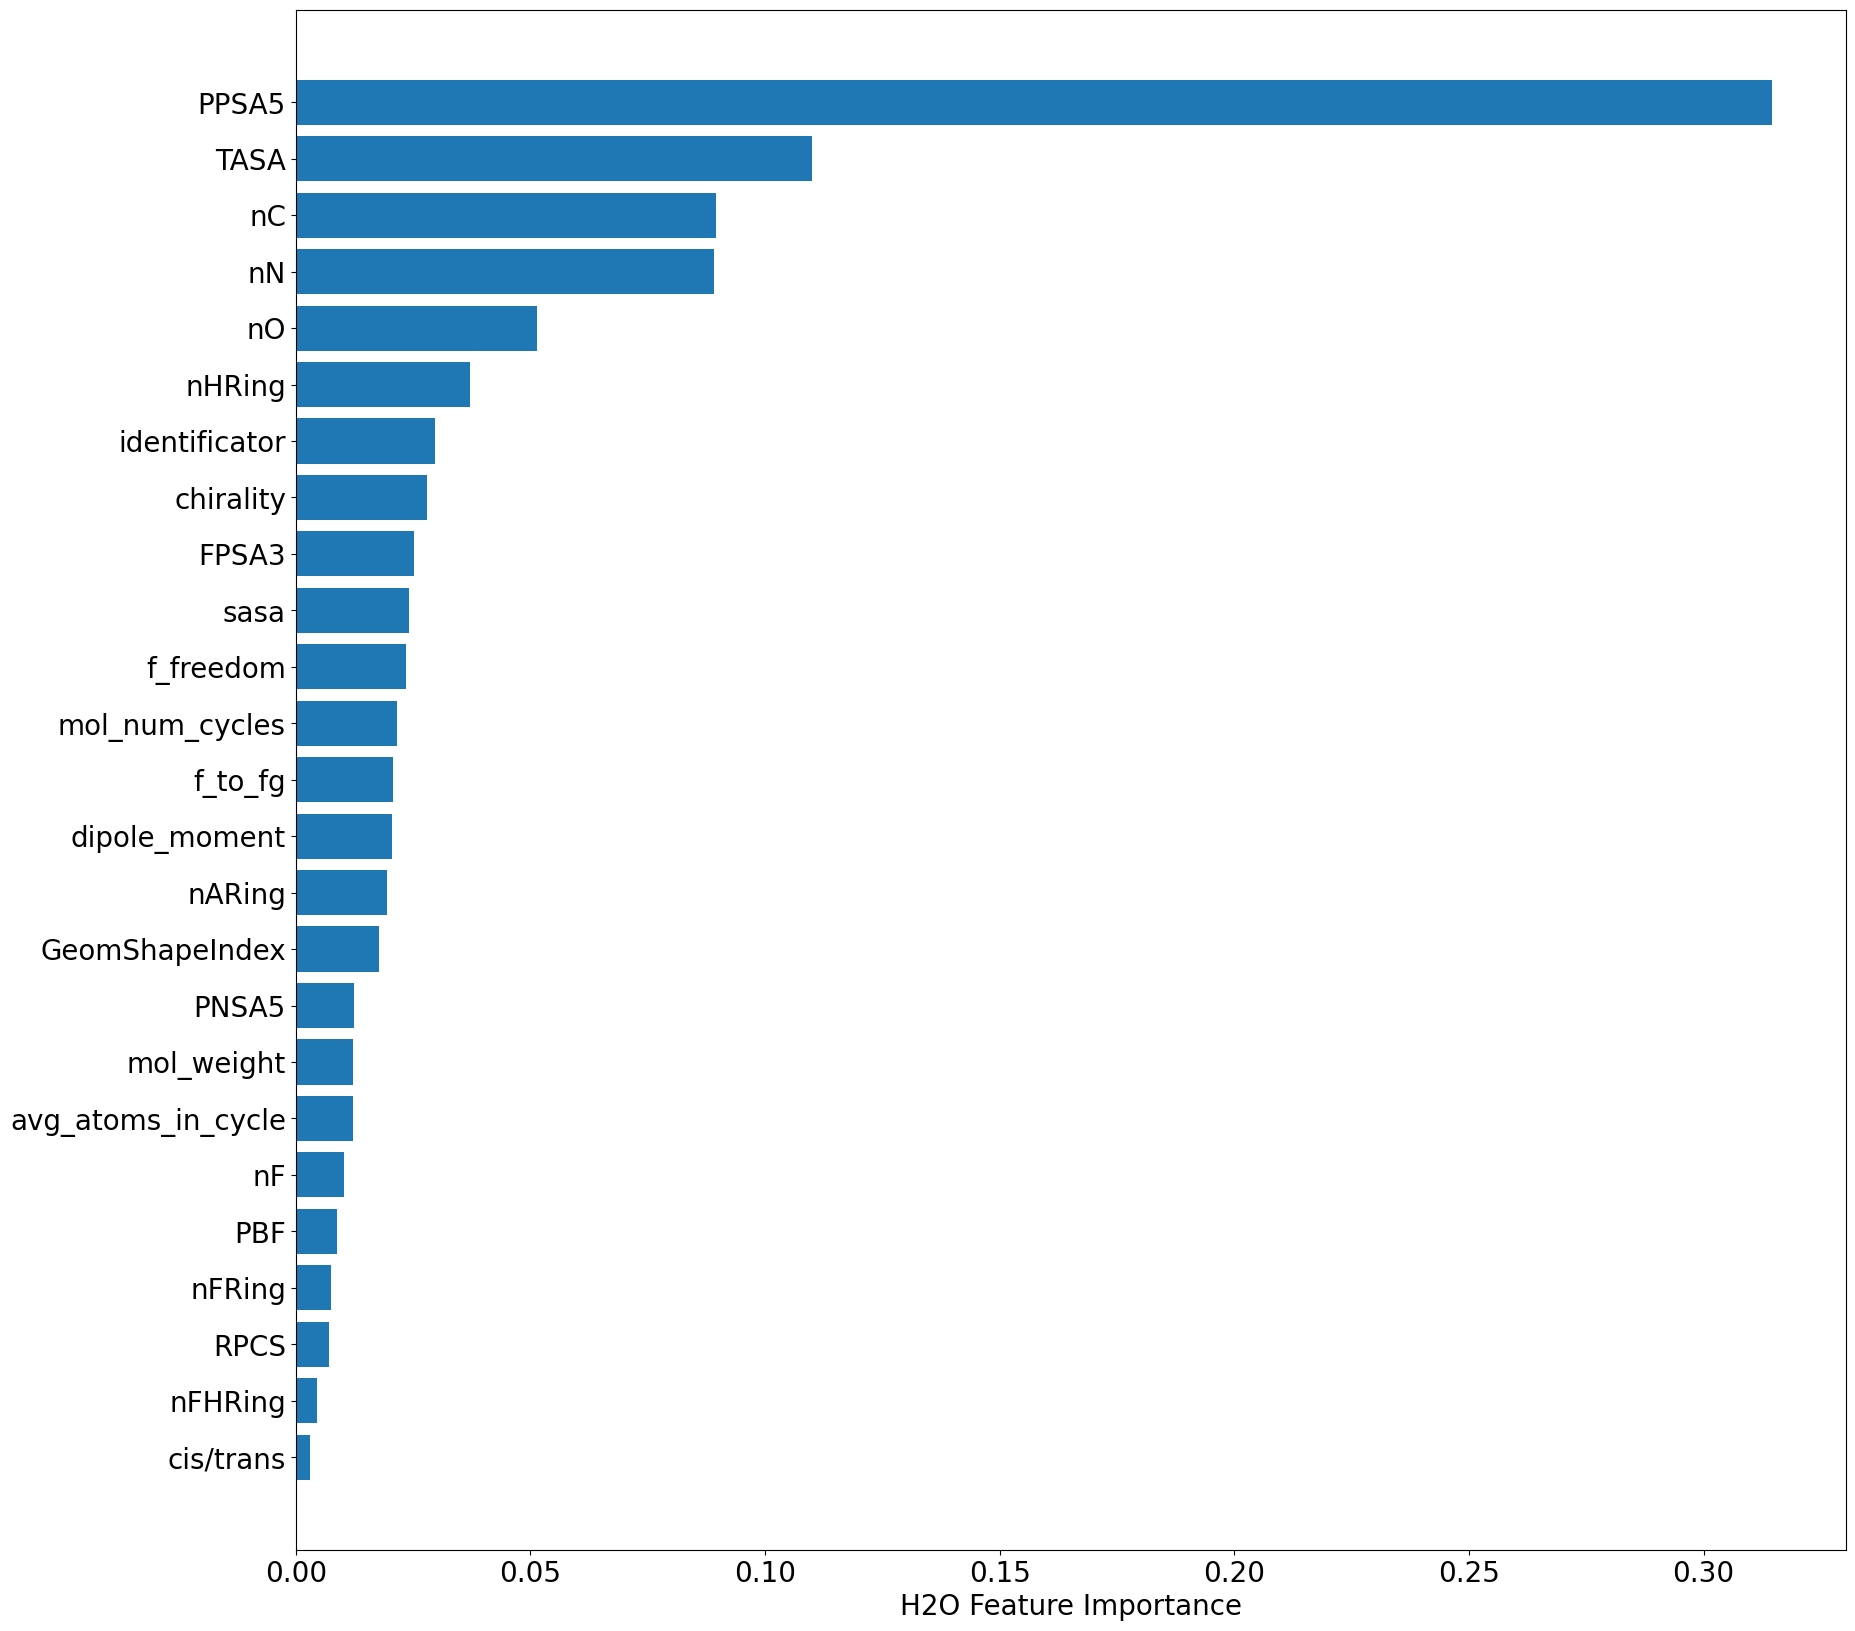

In [12]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

permutation_varimp = best_model.permutation_importance(test, use_pandas=True, n_repeats=1000)

sum_rows = permutation_varimp.sum(axis=1)
sum_rows = sum_rows / sum(sum_rows)

sorted_idx = sum_rows.argsort()
plt.figure(figsize=(20,20))
plt.barh(sum_rows.keys()[sorted_idx][::-1][:][::-1], sum_rows[sorted_idx][::-1][:][::-1])
plt.xlabel("H2O Feature Importance")

SHAP

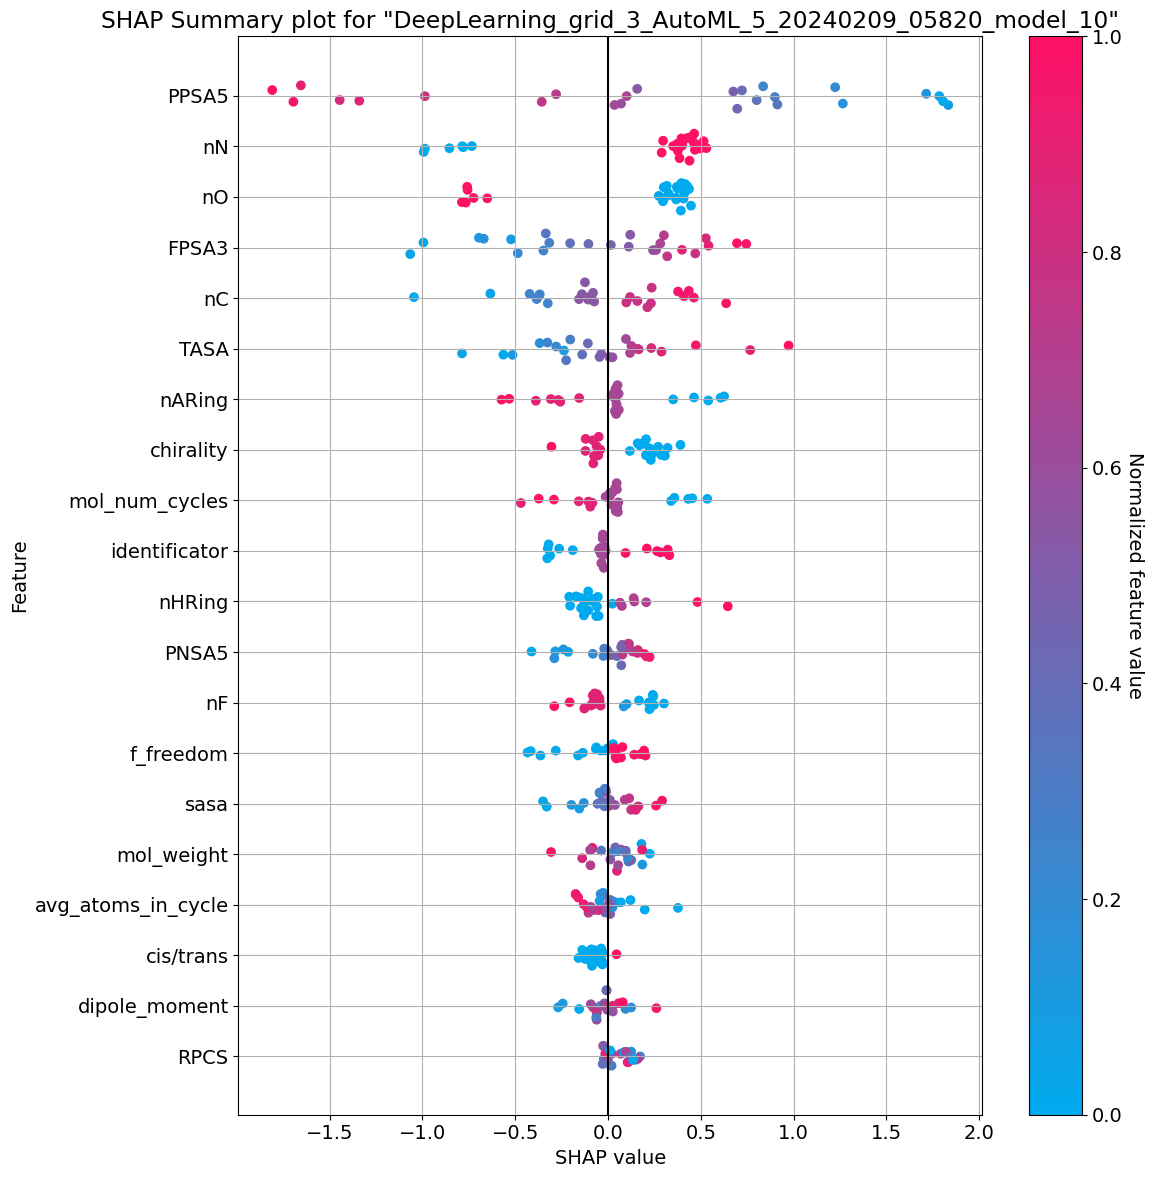

In [13]:
plt.rcParams.update({"font.size": 14})
shap_plot = best_model.shap_summary_plot(test, background_frame=train, samples=1000)

VAR IMPORTANCE

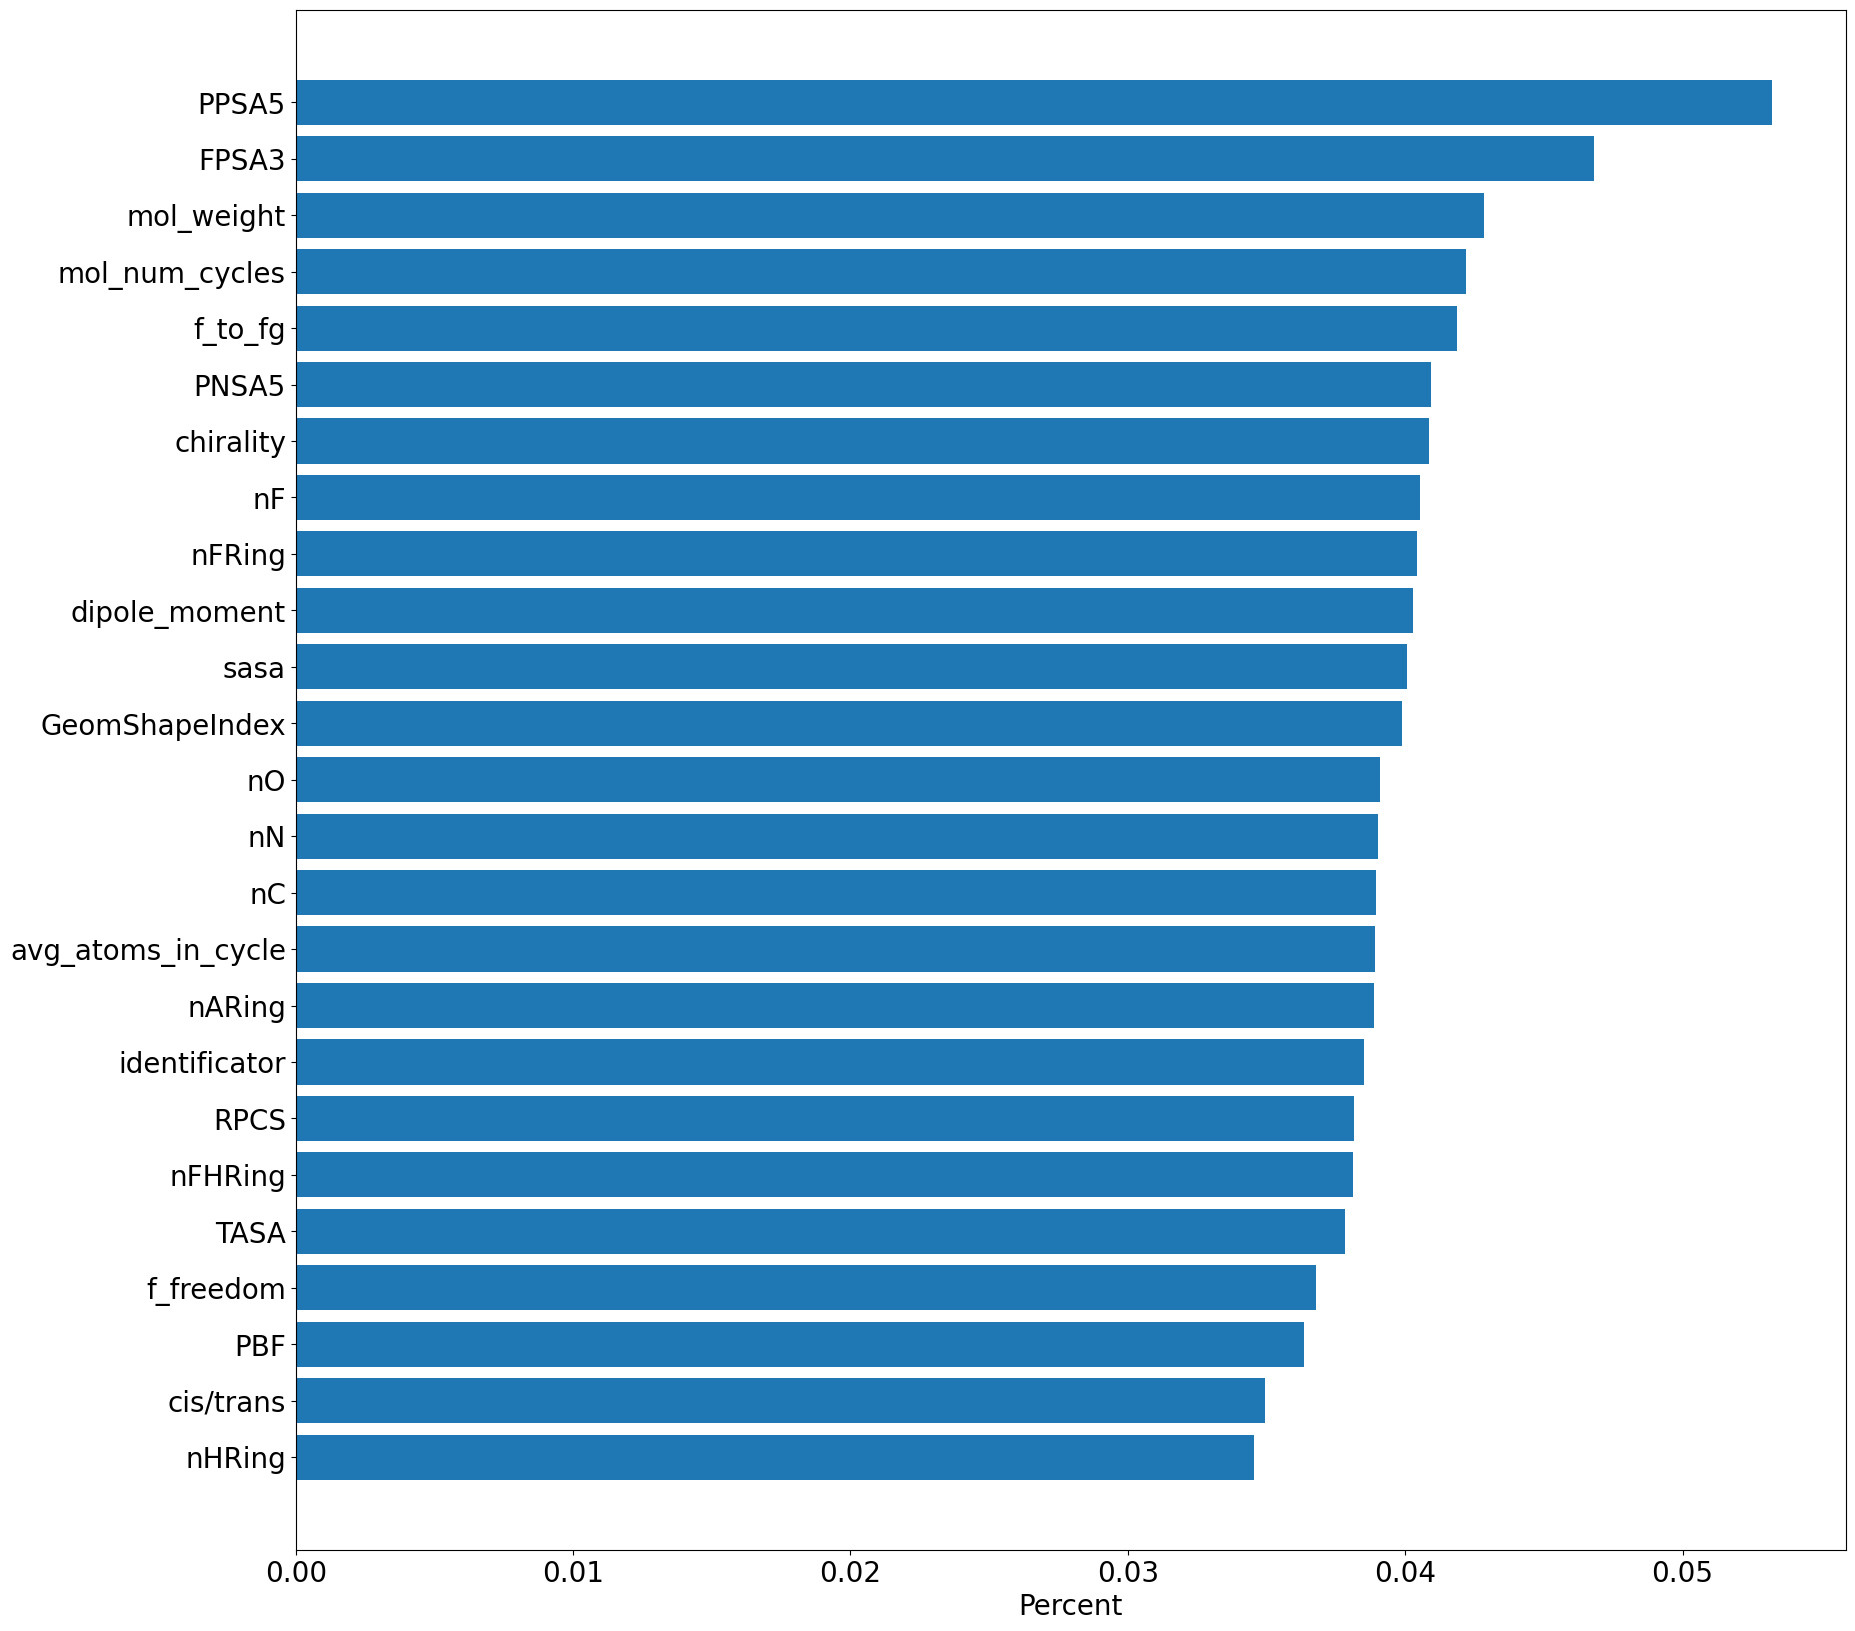

In [14]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

importance = best_model.varimp(test)

if importance is not None:
    fig, ax = plt.subplots(figsize=(20, 20))
    ax.barh(importance['variable'][:][::-1], importance['percentage'][:][::-1])
    ax.set_xlabel('Percent')


In [15]:
import os

MODEL_SAVE_PATH = r'C:\work\DrugDiscovery\main_git\XAI_Chem\ml_part\h2o_model\models\08.02.24_feature_2.2\pKa'

best_model = aml.get_best_model()

model_path = h2o.save_model(model=best_model, path=os.path.join(MODEL_SAVE_PATH, 'all_molecules(without_angle_feature)_without_outliers'), force=True)
model_path

'C:\\work\\DrugDiscovery\\main_git\\XAI_Chem\\ml_part\\h2o_model\\models\\08.02.24_feature_2.2\\pKa\\all_molecules(without_angle_feature)_without_outliers\\DeepLearning_grid_3_AutoML_5_20240209_05820_model_10'

---------------

------------

--------------

------------

----

Molecules only with dihedral angle, with angles as features

In [16]:
import os
import sys
sys.path.insert(0, os.path.dirname('C:\work\DrugDiscovery\main_git\XAI_Chem\ml_part'))

import pandas as pd

from ml_part.random_forest.data_prep.preparation import DataPreparation
from ml_part.random_forest.train import RFTrain

CSV_PATH = r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\remained_features_pKa_08.02_v4_fixed_distances_chirality.csv'
smiles_filepath = r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\smiles_to_index.pkl'

dataPreparation = DataPreparation(CSV_PATH)

outliers_features_to_skip = ['dipole_moment']
X, y = dataPreparation.prepare_data_for_RF(is_pKa=True,
                                           use_mandatory_features=True,
                                           is_remove_outliers=True,
                                           is_remove_nan=True,
                                           outliers_features_to_skip=outliers_features_to_skip)

correlated_features = ['f_atom_fraction', 'naHRing', 'nFaRing', 'nFaHRing', 'tpsa+f']
ring_features_to_remain = ['nFRing', 'nHRing', 'nARing', 'nFHRing']
features_to_drop = []
for feature_name in X.columns:
    if feature_name in correlated_features:
        features_to_drop.append(feature_name)
    elif "ring" in feature_name.lower() and feature_name not in ring_features_to_remain:
        features_to_drop.append(feature_name)
    elif len(X[feature_name].unique()) == 1:
        print(f"feature without unique values: {feature_name}")
        features_to_drop.append(feature_name)

X = X.drop(features_to_drop, axis=1)

rf_train = RFTrain(X=X, 
                   y=y,
                   smiles_filepath=smiles_filepath,
                   is_pKa=True,
                   k_folds=2)

y_train = rf_train.y_train
X_train = rf_train.X_train

y_test = rf_train.y_test
X_test = rf_train.X_test

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

print(len(train_df), len(test_df))

train = h2o.H2OFrame(train_df)
test = h2o.H2OFrame(test_df)

True
183
['RPCS', 'PBF', 'mol_weight', 'dipole_moment', 'PPSA5', 'avg_atoms_in_cycle', 'nHRing', 'cis/trans', 'f_atom_fraction', 'dihedral_angle', 'FPSA3', 'distance_between_atoms_in_cycle_and_f_group', 'angle_X1X2R2', 'nF', 'angle_R1X1R2', 'nFAHRing', 'nAHRing', 'chirality', 'sasa', 'PNSA5', 'GeomShapeIndex', 'TASA', 'angle_R2X2R1', 'mol_num_cycles', 'naRing', 'nN', 'f_freedom', 'tpsa+f', 'nFRing', 'identificator', 'nO', 'distance_between_atoms_in_f_group_centers', 'angle_X2X1R1', 'nARing', 'nFARing', 'nC', 'nFHRing', 'f_to_fg', 'pKa', 'logP']
PBF outliers indexes: [40, 71, 127]
f_atom_fraction outliers indexes: [124]
FPSA3 outliers indexes: [40]
sasa outliers indexes: [127]
PNSA5 outliers indexes: [37, 38]
distance_between_atoms_in_f_group_centers outliers indexes: [35]
logP outliers indexes: [82, 83]
Remains rows:105, amount of features: 40
92 13


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [17]:
x = train.columns
y = "pKa"
x.remove(y)

aml = H2OAutoML(seed=1, max_runtime_secs_per_model=300)
aml.train(x=x, y=y, training_frame=train, fold_column="fold_id")

lb = aml.leaderboard
print(lb.head(rows=lb.nrows))

AutoML progress: |█
02:00:59.460: Fold column fold_id will be used for cross-validation. nfolds parameter will be ignored.
02:00:59.461: AutoML: XGBoost is not available; skipping it.
02:00:59.507: _min_rows param, The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 92.0.

██████████████████████████████████████████████████████████████| (done) 100%
model_id                                                    rmse       mse       mae      rmsle    mean_residual_deviance
DeepLearning_grid_2_AutoML_6_20240209_20059_model_39    0.615549  0.378901  0.456933  0.0759462                  0.378901
StackedEnsemble_BestOfFamily_6_AutoML_6_20240209_20059  0.648873  0.421036  0.495847  0.0789859                  0.421036
GBM_grid_1_AutoML_6_20240209_20059_model_523            0.654489  0.428356  0.48764   0.08041                    0.428356
DeepLearning_grid_2_AutoML_6_20240209_20059_model_10    0.657442  0.432231  0.510444  0.0822918    

TRAIN

In [18]:
best_model = aml.get_best_model()
preds = best_model.predict(train)
true = train.as_data_frame()['pKa']
predicted_values = preds.as_data_frame()['predict']

calculate_metrics(true, predicted_values)

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


{'mse': 0.001, 'mae': 0.028, 'r^2': 1.0}

OOS

In [19]:
best_model = aml.get_best_model()
preds = best_model.predict(test)
true = test.as_data_frame()['pKa']
predicted_values = preds.as_data_frame()['predict']

calculate_metrics(true, predicted_values)

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


{'mse': 0.206, 'mae': 0.352, 'r^2': 0.961}

BEST_MODEL(for cross-val metrics)

In [20]:
best_model

Model Details
=============
H2ODeepLearningEstimator : Deep Learning
Model Key: DeepLearning_grid_2_AutoML_6_20240209_20059_model_39


Status of Neuron Layers: predicting pKa, regression, gaussian distribution, Quadratic loss, 13 501 weights/biases, 168,0 KB, 920 000 training samples, mini-batch size 1
    layer    units    type              dropout    l1    l2    mean_rate            rate_rms             momentum    mean_weight            weight_rms           mean_bias             bias_rms
--  -------  -------  ----------------  ---------  ----  ----  -------------------  -------------------  ----------  ---------------------  -------------------  --------------------  -----------------------
    1        32       Input             0.0
    2        100      RectifierDropout  0.0        0.0   0.0   0.7952834203233943   0.14597612619400024  0.0         -0.005467803958222248  0.15240925550460815  0.18183975994492904   0.18730652332305908
    3        100      RectifierDropout  0.0        0.0   0.0   0.8867596247731708   0.1952875256538391   0.0         -0.0367293579278994    0.10330858826637268  0.9384212697180989    0.09969347715377808
    4        1        Linear                       0.0   0.0   0.42318432164378467  0.3165081739425659   0.0         0.00466745334706502    0.03296780586242676  0.048879289469731704  1.0971281125650402e-154

ModelMetricsRegression: deeplearning
** Reported on train data. **

MSE: 0.001196342671371252
RMSE: 0.03458818687603113
MAE: 0.027658728314308177
RMSLE: 0.005824508049409396
Mean Residual Deviance: 0.001196342671371252

ModelMetricsRegression: deeplearning
** Reported on cross-validation data. **

MSE: 0.3789010860410212
RMSE: 0.6155494180332081
MAE: 0.456933006218419
RMSLE: 0.07594617277772306
Mean Residual Deviance: 0.3789010860410212

Cross-Validation Metrics Summary: 
                        mean       sd          cv_1_valid    cv_2_valid
----------------------  ---------  ----------  ------------  ------------
mae                     0.456933   0.0156231   0.445886      0.46798
mean_residual_deviance  0.378901   0.0104854   0.386315      0.371487
mse                     0.378901   0.0104854   0.386315      0.371487
r2                      0.921673   0.00329799  0.924005      0.919341
residual_deviance       0.378901   0.0104854   0.386315      0.371487
rmse                    0.61552    0.00851748  0.621543      0.609497
rmsle                   0.0759416  0.00118455  0.075104      0.0767792

Scoring History: 
    timestamp            duration           training_speed    epochs    iterations    samples    training_rmse    training_deviance    training_mae    training_r2
--  -------------------  -----------------  ----------------  --------  ------------  ---------  ---------------  -------------------  --------------  -------------
    2024-02-09 02:24:04  0.000 sec                            0         0             0          nan              nan                  nan             nan
    2024-02-09 02:24:04  11 min 36.781 sec  18400 obs/sec     10        1             920        0.526872         0.277594             0.376861        0.942799
    2024-02-09 02:24:09  11 min 41.794 sec  48172 obs/sec     2650      265           243800     0.030504         0.000930495          0.0252613       0.999808
    2024-02-09 02:24:14  11 min 46.804 sec  58659 obs/sec     6420      642           590640     0.0189279        0.000358265          0.0131094       0.999926
    2024-02-09 02:24:19  11 min 51.326 sec  63065 obs/sec     10000     1000          920000     0.0345882        0.00119634           0.0276587       0.999753

Variable Importances: 
variable                                   relative_importance    scaled_importance    percentage
-----------------------------------------  ---------------------  -------------------  --------------------
PPSA5                                      1.0                    1.0                  0.04933244986346685
nN                                         0.76

PERMUTATION IMPORTANCE

c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


C:\Users\38066\AppData\Local\Temp\ipykernel_22280\1575081460.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.barh(sum_rows.keys()[sorted_idx][::-1][:][::-1], sum_rows[sorted_idx][::-1][:][::-1])


Text(0.5, 0, 'H2O Feature Importance')

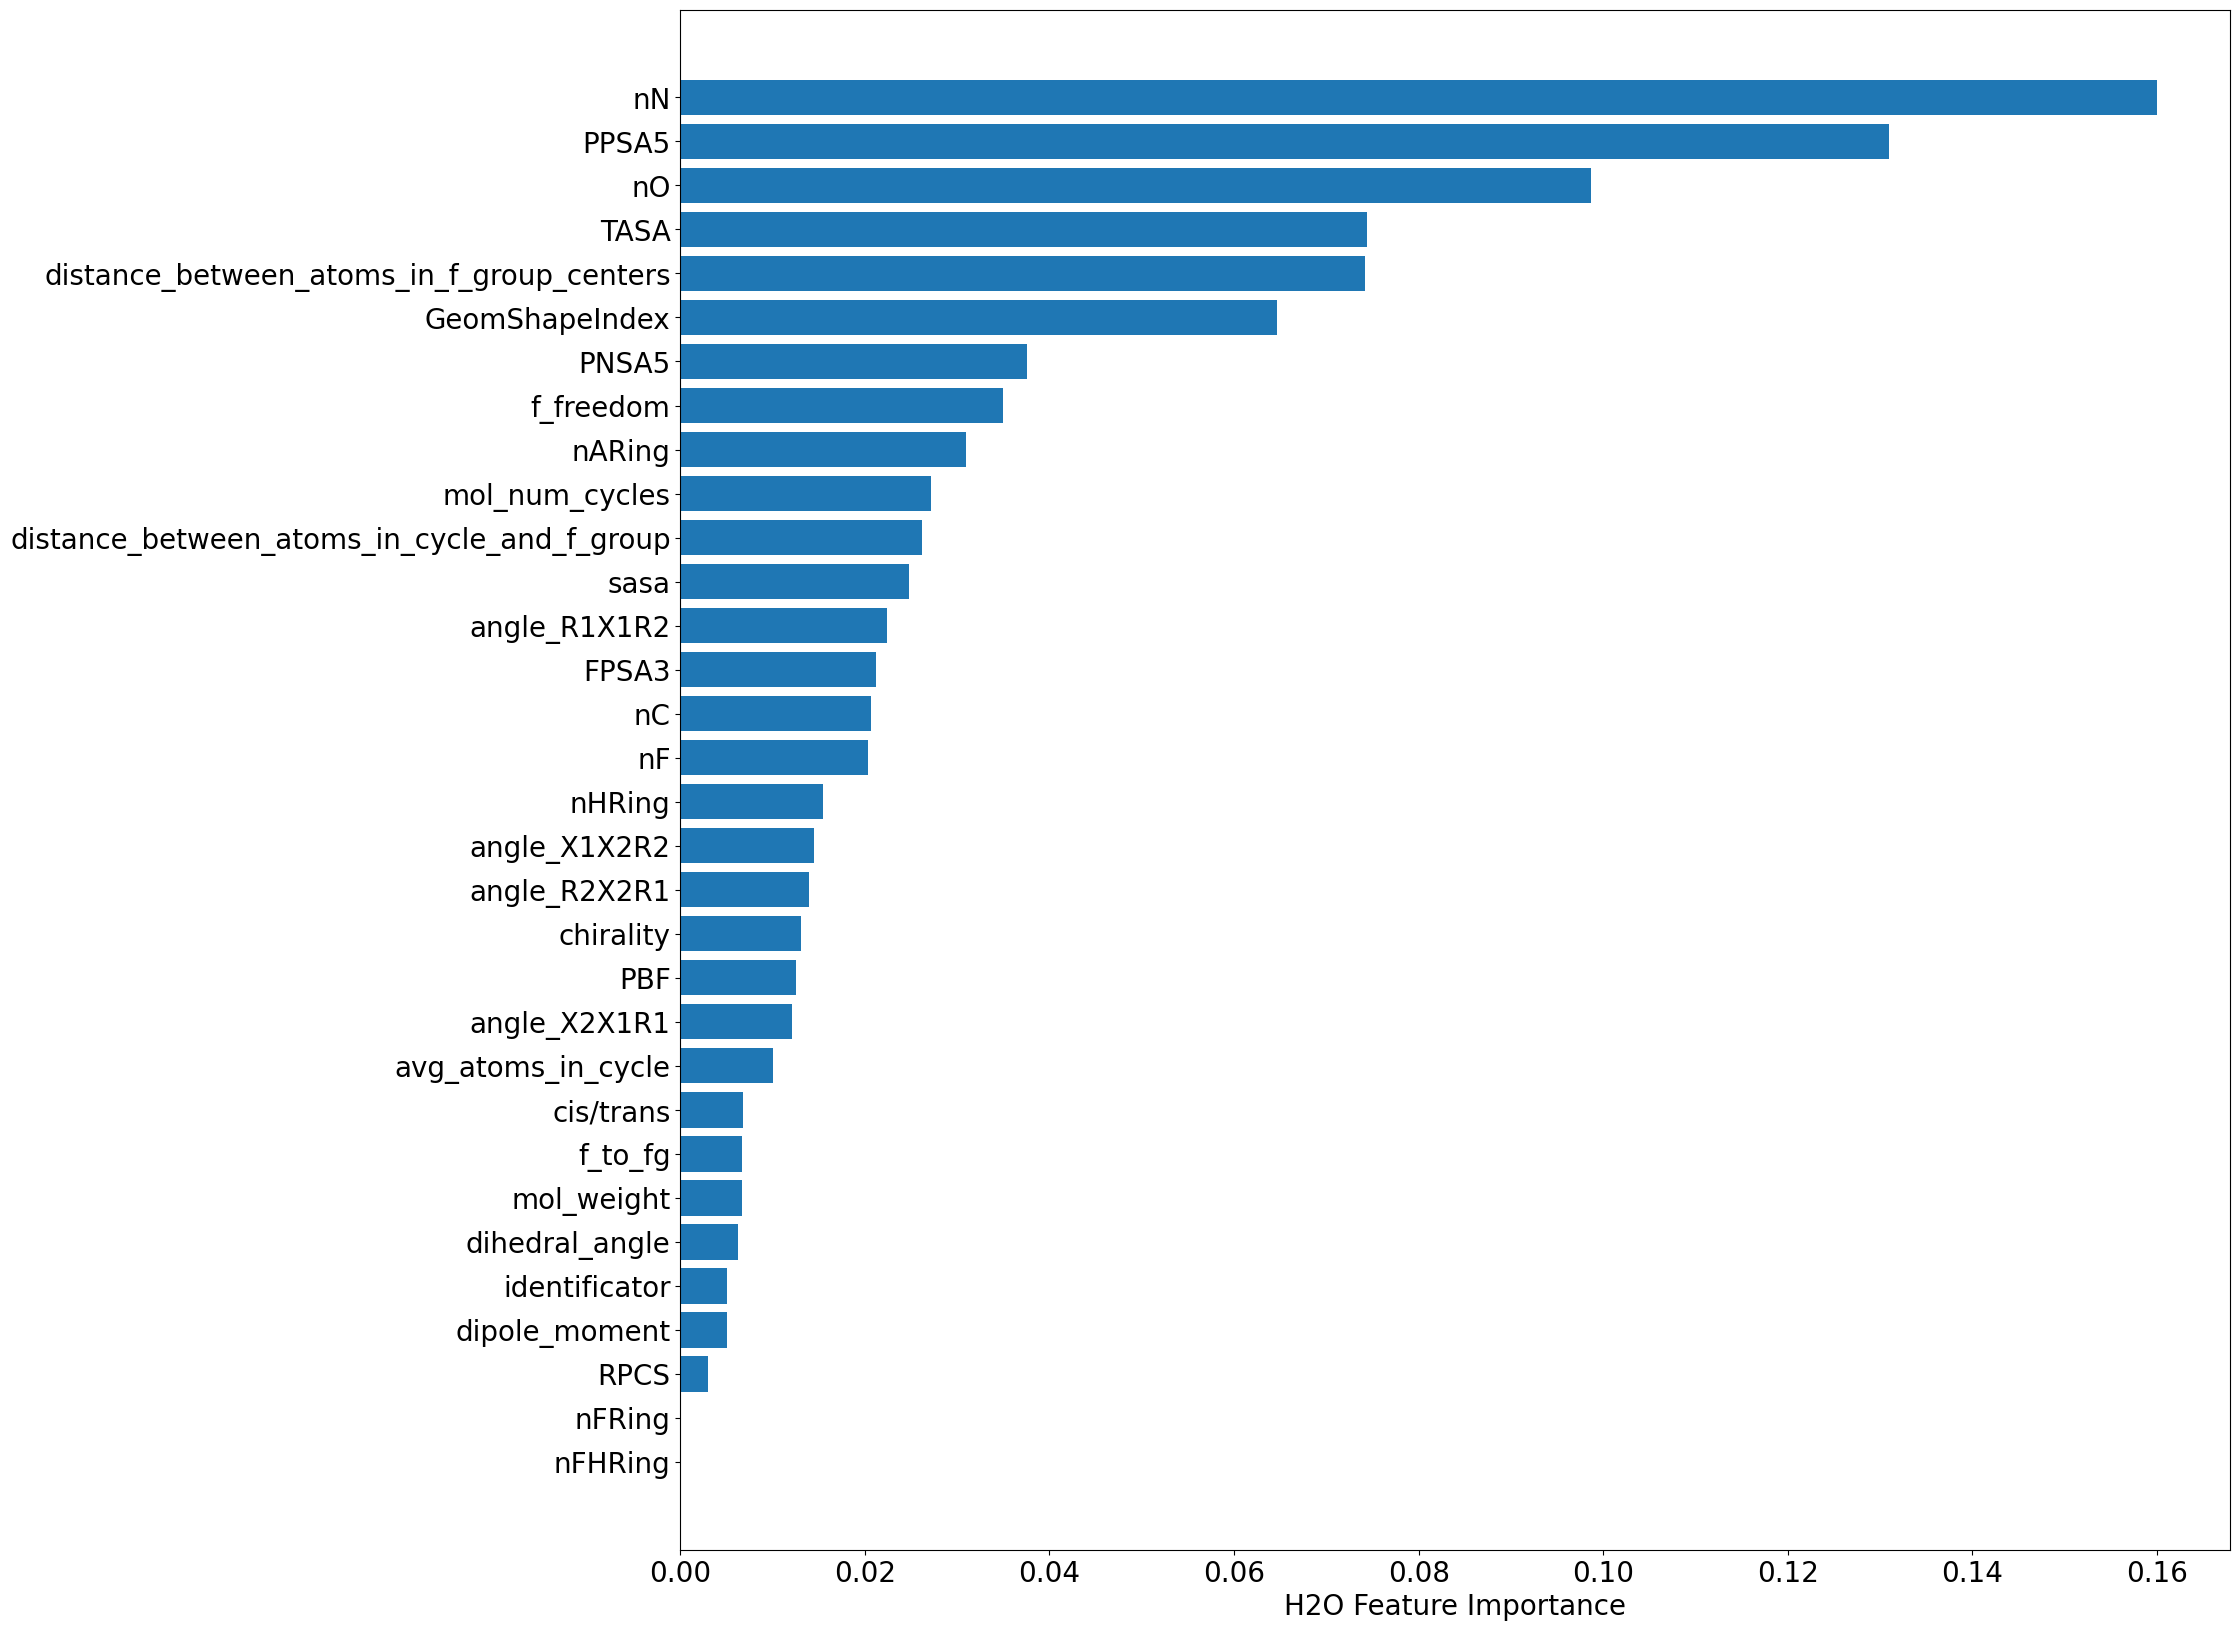

In [21]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

permutation_varimp = best_model.permutation_importance(test, use_pandas=True, n_repeats=1000)

sum_rows = permutation_varimp.sum(axis=1)
sum_rows = sum_rows / sum(sum_rows)

sorted_idx = sum_rows.argsort()
plt.figure(figsize=(20,20))
plt.barh(sum_rows.keys()[sorted_idx][::-1][:][::-1], sum_rows[sorted_idx][::-1][:][::-1])
plt.xlabel("H2O Feature Importance")

SHAP

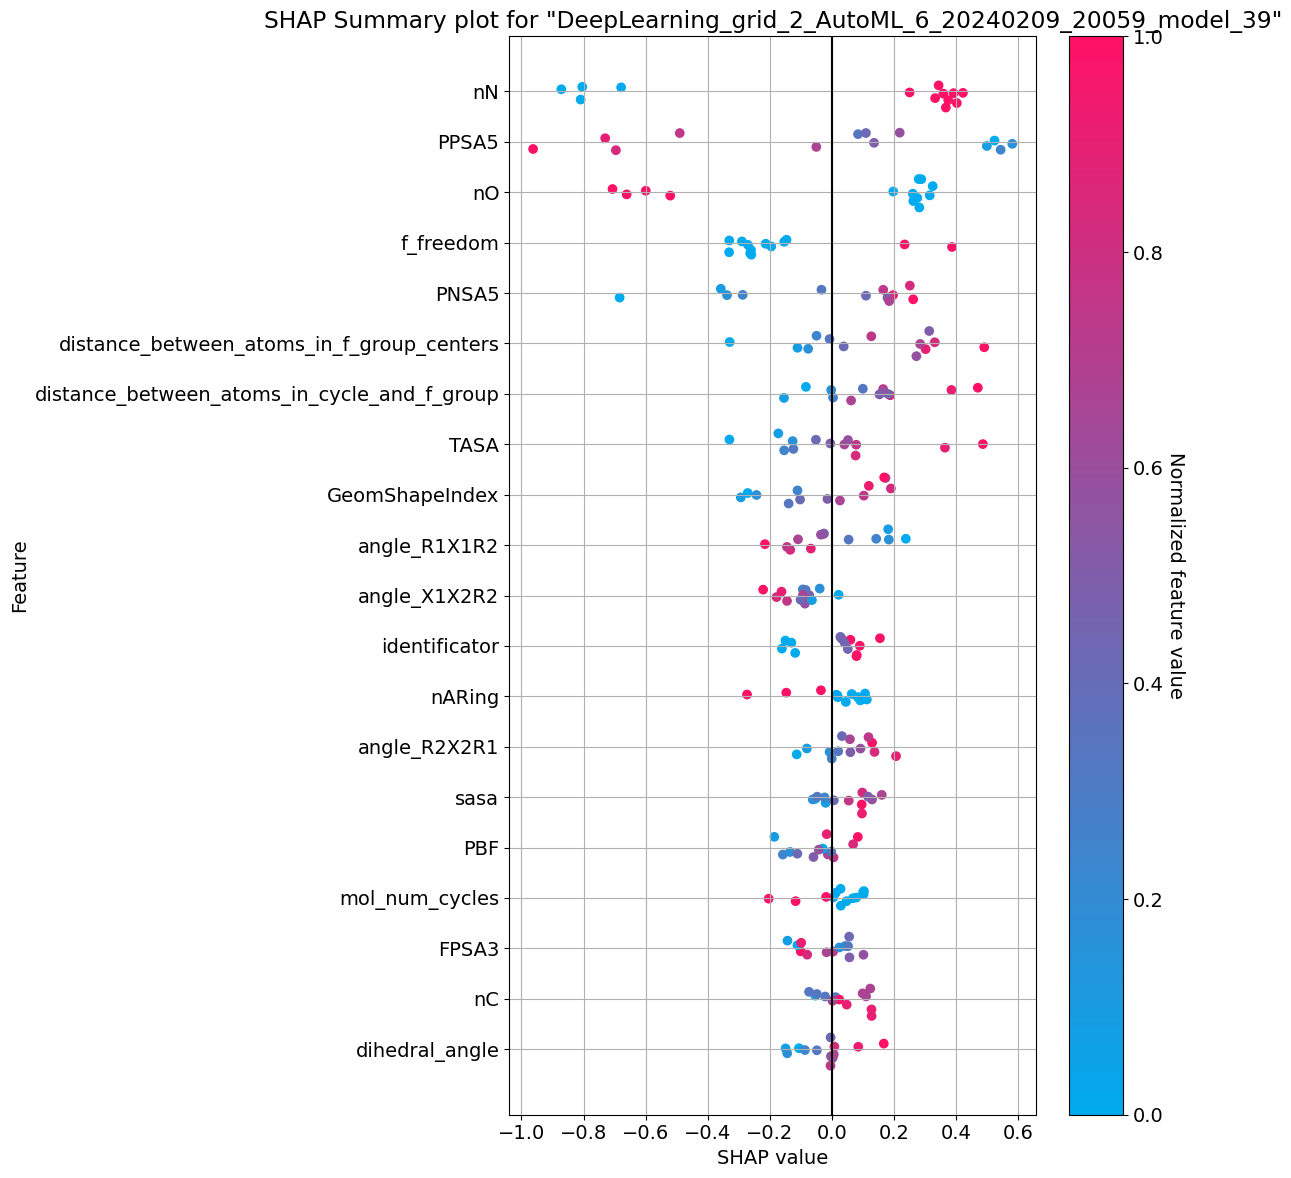

In [22]:
plt.rcParams.update({"font.size": 14})
shap_plot = best_model.shap_summary_plot(test, background_frame=train, samples=1000)

VAR IMPORTANCE

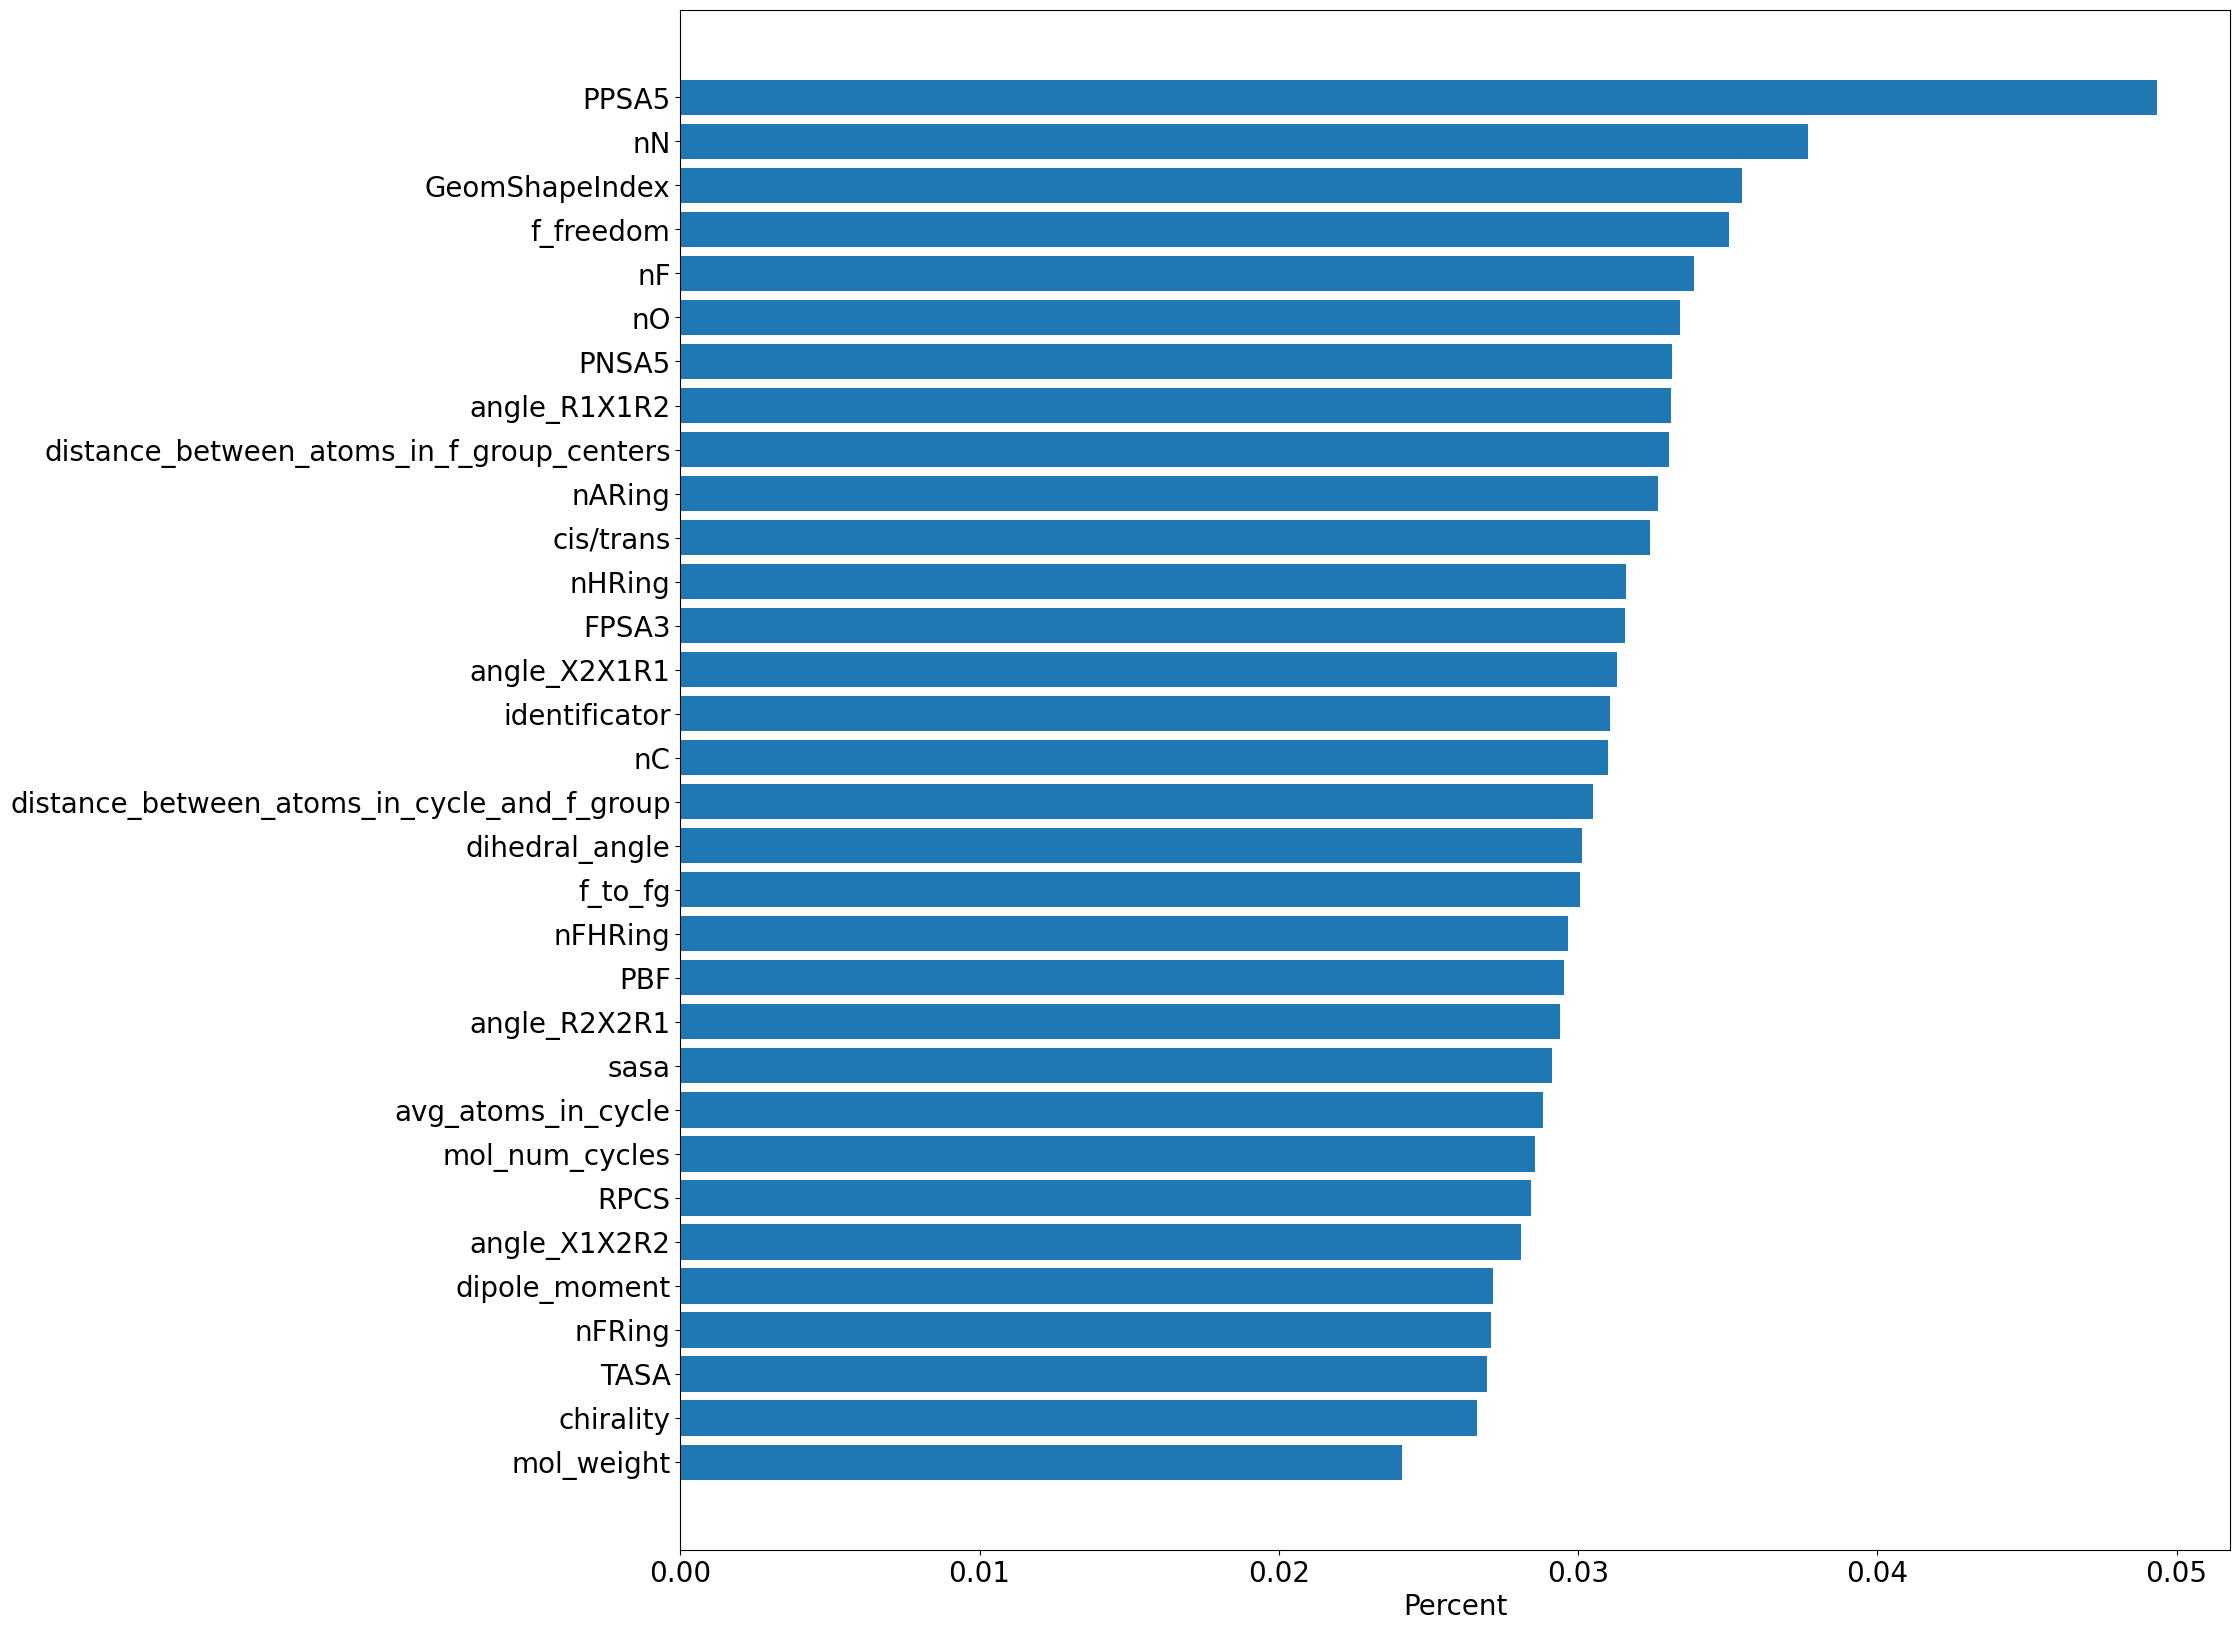

In [23]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

importance = best_model.varimp(test)

if importance is not None:
    fig, ax = plt.subplots(figsize=(20, 20))
    ax.barh(importance['variable'][:][::-1], importance['percentage'][:][::-1])
    ax.set_xlabel('Percent')


In [24]:
import os

MODEL_SAVE_PATH = r'C:\work\DrugDiscovery\main_git\XAI_Chem\ml_part\h2o_model\models\08.02.24_feature_2.2\pKa'

best_model = aml.get_best_model()

model_path = h2o.save_model(model=best_model, path=os.path.join(MODEL_SAVE_PATH, 'only_molecules_with_dihedral_angle(with_angle_feature)_without_outliers'), force=True)
model_path

'C:\\work\\DrugDiscovery\\main_git\\XAI_Chem\\ml_part\\h2o_model\\models\\08.02.24_feature_2.2\\pKa\\only_molecules_with_dihedral_angle(with_angle_feature)_without_outliers\\DeepLearning_grid_2_AutoML_6_20240209_20059_model_39'

---------------

--------------

--------

------------

------------

In [25]:
import os
import sys
sys.path.insert(0, os.path.dirname('C:\work\DrugDiscovery\main_git\XAI_Chem\ml_part'))

import pandas as pd

from ml_part.random_forest.data_prep.preparation import DataPreparation
from ml_part.random_forest.train import RFTrain

CSV_PATH = r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\remained_features_pKa_08.02_v4_fixed_distances_chirality.csv'
smiles_filepath = r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\smiles_to_index.pkl'

dataPreparation = DataPreparation(CSV_PATH)

outliers_features_to_skip = ['dipole_moment']
X, y = dataPreparation.prepare_data_for_RF(is_pKa=True,
                                           use_mandatory_features=True,
                                           is_remove_outliers=True,
                                           is_remove_nan=True,
                                           outliers_features_to_skip=outliers_features_to_skip)

correlated_features = ['f_atom_fraction', 'naHRing', 'nFaRing', 'nFaHRing', 'tpsa+f']
ring_features_to_remain = ['nFRing', 'nHRing', 'nARing', 'nFHRing']
features_to_drop = []
for feature_name in X.columns:
    if feature_name in correlated_features:
        features_to_drop.append(feature_name)
    elif "ring" in feature_name.lower() and feature_name not in ring_features_to_remain:
        features_to_drop.append(feature_name)
    elif len(X[feature_name].unique()) == 1:
        print(f"feature without unique values: {feature_name}")
        features_to_drop.append(feature_name)
    elif "angle" in feature_name or "distance" in feature_name:
        features_to_drop.append(feature_name)

X = X.drop(features_to_drop, axis=1)

rf_train = RFTrain(X=X, 
                   y=y,
                   smiles_filepath=smiles_filepath,
                   is_pKa=True,
                   k_folds=2)

y_train = rf_train.y_train
X_train = rf_train.X_train

y_test = rf_train.y_test
X_test = rf_train.X_test

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

print(len(train_df), len(test_df))

train = h2o.H2OFrame(train_df)
test = h2o.H2OFrame(test_df)

True
183
['RPCS', 'PBF', 'mol_weight', 'dipole_moment', 'PPSA5', 'avg_atoms_in_cycle', 'nHRing', 'cis/trans', 'f_atom_fraction', 'dihedral_angle', 'FPSA3', 'distance_between_atoms_in_cycle_and_f_group', 'angle_X1X2R2', 'nF', 'angle_R1X1R2', 'nFAHRing', 'nAHRing', 'chirality', 'sasa', 'PNSA5', 'GeomShapeIndex', 'TASA', 'angle_R2X2R1', 'mol_num_cycles', 'naRing', 'nN', 'f_freedom', 'tpsa+f', 'nFRing', 'identificator', 'nO', 'distance_between_atoms_in_f_group_centers', 'angle_X2X1R1', 'nARing', 'nFARing', 'nC', 'nFHRing', 'f_to_fg', 'pKa', 'logP']
PBF outliers indexes: [40, 71, 127]
f_atom_fraction outliers indexes: [124]
FPSA3 outliers indexes: [40]
sasa outliers indexes: [127]
PNSA5 outliers indexes: [37, 38]
distance_between_atoms_in_f_group_centers outliers indexes: [35]
logP outliers indexes: [82, 83]
Remains rows:105, amount of features: 40
92 13


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [26]:
x = train.columns
y = "pKa"
x.remove(y)

aml = H2OAutoML(seed=1, max_runtime_secs_per_model=300)
aml.train(x=x, y=y, training_frame=train, fold_column="fold_id")

lb = aml.leaderboard
print(lb.head(rows=lb.nrows))

AutoML progress: |█
03:01:19.155: Fold column fold_id will be used for cross-validation. nfolds parameter will be ignored.
03:01:19.156: AutoML: XGBoost is not available; skipping it.
03:01:19.194: _min_rows param, The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 92.0.

██████████████████████████████████████████████████████████████| (done) 100%
model_id                                                    rmse       mse       mae      rmsle    mean_residual_deviance
DeepLearning_grid_1_AutoML_7_20240209_30119_model_139   0.677455  0.458945  0.514736  0.0790601                  0.458945
GBM_grid_1_AutoML_7_20240209_30119_model_599            0.701572  0.492203  0.518289  0.086302                   0.492203
DeepLearning_grid_3_AutoML_7_20240209_30119_model_10    0.704477  0.496287  0.523395  0.0851644                  0.496287
GBM_grid_1_AutoML_7_20240209_30119_model_415            0.712259  0.507313  0.490835  0.0842204    

TRAIN

In [27]:
best_model = aml.get_best_model()
preds = best_model.predict(train)
true = train.as_data_frame()['pKa']
predicted_values = preds.as_data_frame()['predict']

calculate_metrics(true, predicted_values)

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


{'mse': 0.02, 'mae': 0.112, 'r^2': 0.996}

OOS

In [28]:
best_model = aml.get_best_model()
preds = best_model.predict(test)
true = test.as_data_frame()['pKa']
predicted_values = preds.as_data_frame()['predict']

calculate_metrics(true, predicted_values)

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


{'mse': 0.596, 'mae': 0.645, 'r^2': 0.886}

BEST_MODEL(for cross-val metrics)

In [29]:
best_model

Model Details
=============
H2ODeepLearningEstimator : Deep Learning
Model Key: DeepLearning_grid_1_AutoML_7_20240209_30119_model_139


Status of Neuron Layers: predicting pKa, regression, gaussian distribution, Quadratic loss, 2 701 weights/biases, 38,5 KB, 920 000 training samples, mini-batch size 1
    layer    units    type              dropout    l1    l2    mean_rate             rate_rms               momentum    mean_weight             weight_rms           mean_bias            bias_rms
--  -------  -------  ----------------  ---------  ----  ----  --------------------  ---------------------  ----------  ----------------------  -------------------  -------------------  -----------------------
    1        25       Input             5.0
    2        100      RectifierDropout  10.0       0.0   0.0   0.08887577761281282   0.056248024106025696   0.0         -0.0011047865207568974  0.222062349319458    -0.3381616761436038  0.44844233989715576
    3        1        Linear                       0.0   0.0   0.007017545651178807  0.0027699749916791916  0.0         -0.01621582917869091    0.11397692561149597  0.28629522445599953  1.0971281125650402e-154

ModelMetricsRegression: deeplearning
** Reported on train data. **

MSE: 0.01956228651206769
RMSE: 0.13986524411757084
MAE: 0.11206671386245058
RMSLE: 0.022967207622583183
Mean Residual Deviance: 0.01956228651206769

ModelMetricsRegression: deeplearning
** Reported on cross-validation data. **

MSE: 0.45894518638117826
RMSE: 0.6774549330997437
MAE: 0.5147359996715241
RMSLE: 0.07906013673549793
Mean Residual Deviance: 0.45894518638117826

Cross-Validation Metrics Summary: 
                        mean       sd          cv_1_valid    cv_2_valid
----------------------  ---------  ----------  ------------  ------------
mae                     0.514736   0.0730092   0.463111      0.566361
mean_residual_deviance  0.458945   0.0292982   0.438228      0.479662
mse                     0.458945   0.0292982   0.438228      0.479662
r2                      0.904823   0.0126851   0.913793      0.895853
residual_deviance       0.458945   0.0292982   0.438228      0.479662
rmse                    0.677282   0.0216293   0.661988      0.692576
rmsle                   0.0788897  0.00733708  0.0737016     0.0840778

Scoring History: 
    timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_deviance    training_mae    training_r2
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  -------------------  --------------  -------------
    2024-02-09 03:52:40  0.000 sec                           0         0             0          nan              nan                  nan             nan
    2024-02-09 03:52:40  1 min 47.141 sec  102222 obs/sec    10        1             920        0.721102         0.519988             0.584959        0.892851
    2024-02-09 03:52:45  1 min 52.142 sec  162180 obs/sec    8830      883           812360     0.201463         0.0405873            0.165132        0.991637
    2024-02-09 03:52:46  1 min 52.744 sec  163963 obs/sec    10000     1000          920000     0.139865         0.0195623            0.112067        0.995969

Variable Importances: 
variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
PPSA5               1.0                    1.0                  0.08016439945619545
nN                  0.902810275554657      0.902810275554657    0.07237324356272141
FPSA3               0.8173521757125854     0.8173521757125854   0.06552254631021416
nO                  0.7449590563774109     0.7449590563774109   0.059719195373949194
PNSA5               0.6443893909454346     0.6443893909454346   0.05165708854108431
nF                  0.6335194706916809     0.6335194706916809   0.050785707911805415
GeomShapeIndex      0.5900236964225769     0.590023

PERMUTATION IMPORTANCE

c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


C:\Users\38066\AppData\Local\Temp\ipykernel_22280\1575081460.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.barh(sum_rows.keys()[sorted_idx][::-1][:][::-1], sum_rows[sorted_idx][::-1][:][::-1])


Text(0.5, 0, 'H2O Feature Importance')

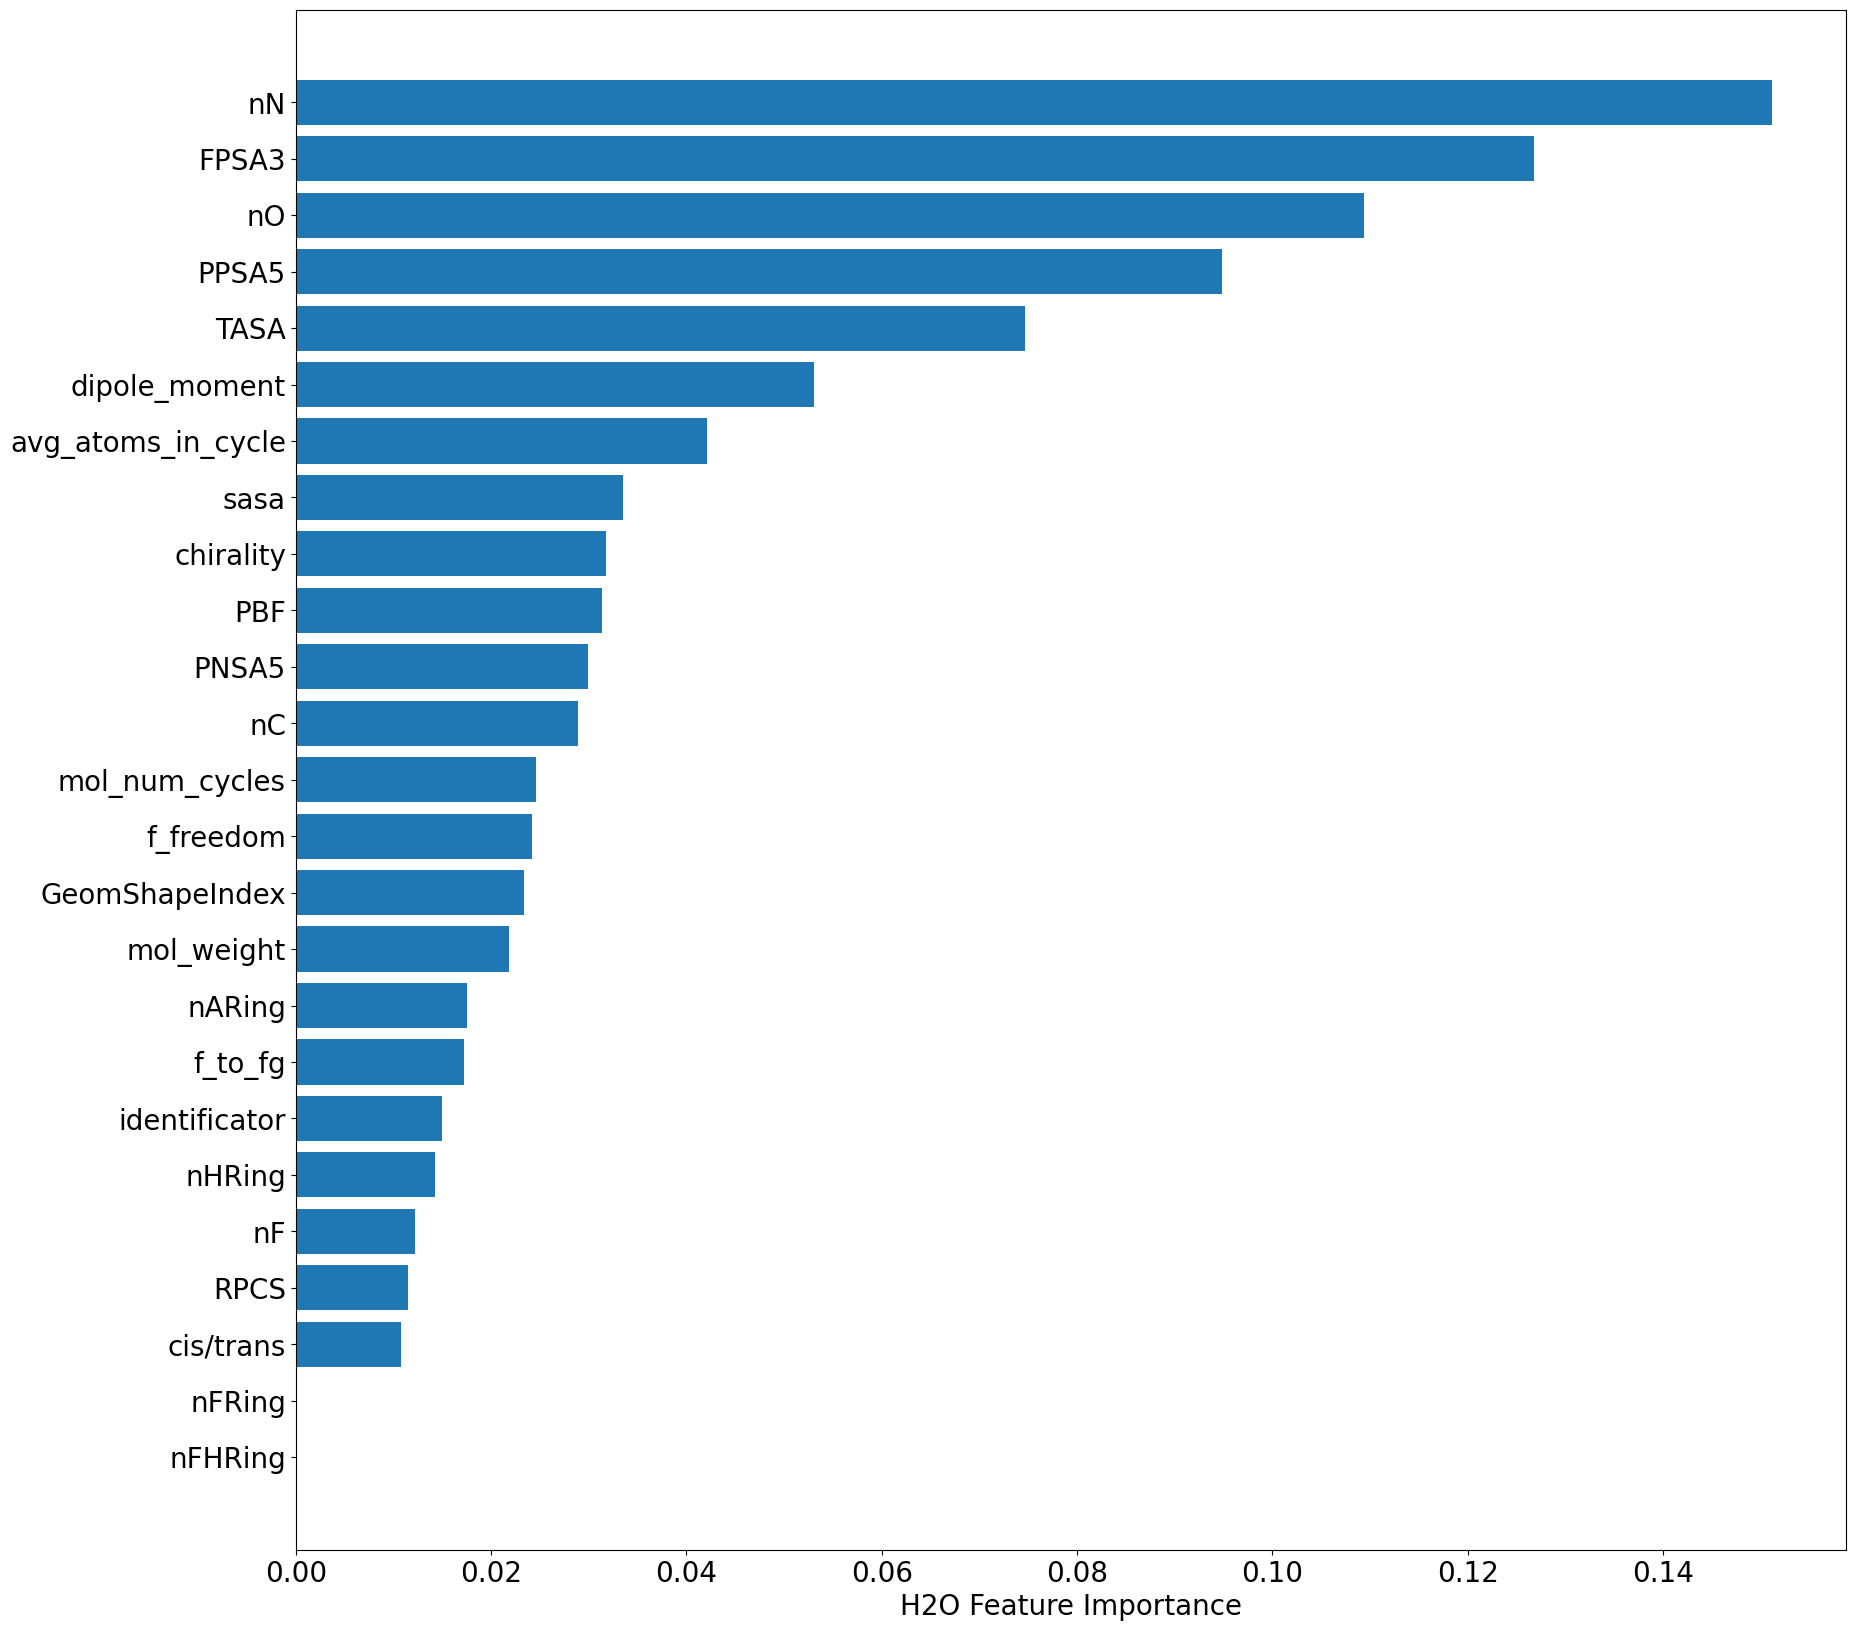

In [30]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

permutation_varimp = best_model.permutation_importance(test, use_pandas=True, n_repeats=1000)

sum_rows = permutation_varimp.sum(axis=1)
sum_rows = sum_rows / sum(sum_rows)

sorted_idx = sum_rows.argsort()
plt.figure(figsize=(20,20))
plt.barh(sum_rows.keys()[sorted_idx][::-1][:][::-1], sum_rows[sorted_idx][::-1][:][::-1])
plt.xlabel("H2O Feature Importance")

SHAP

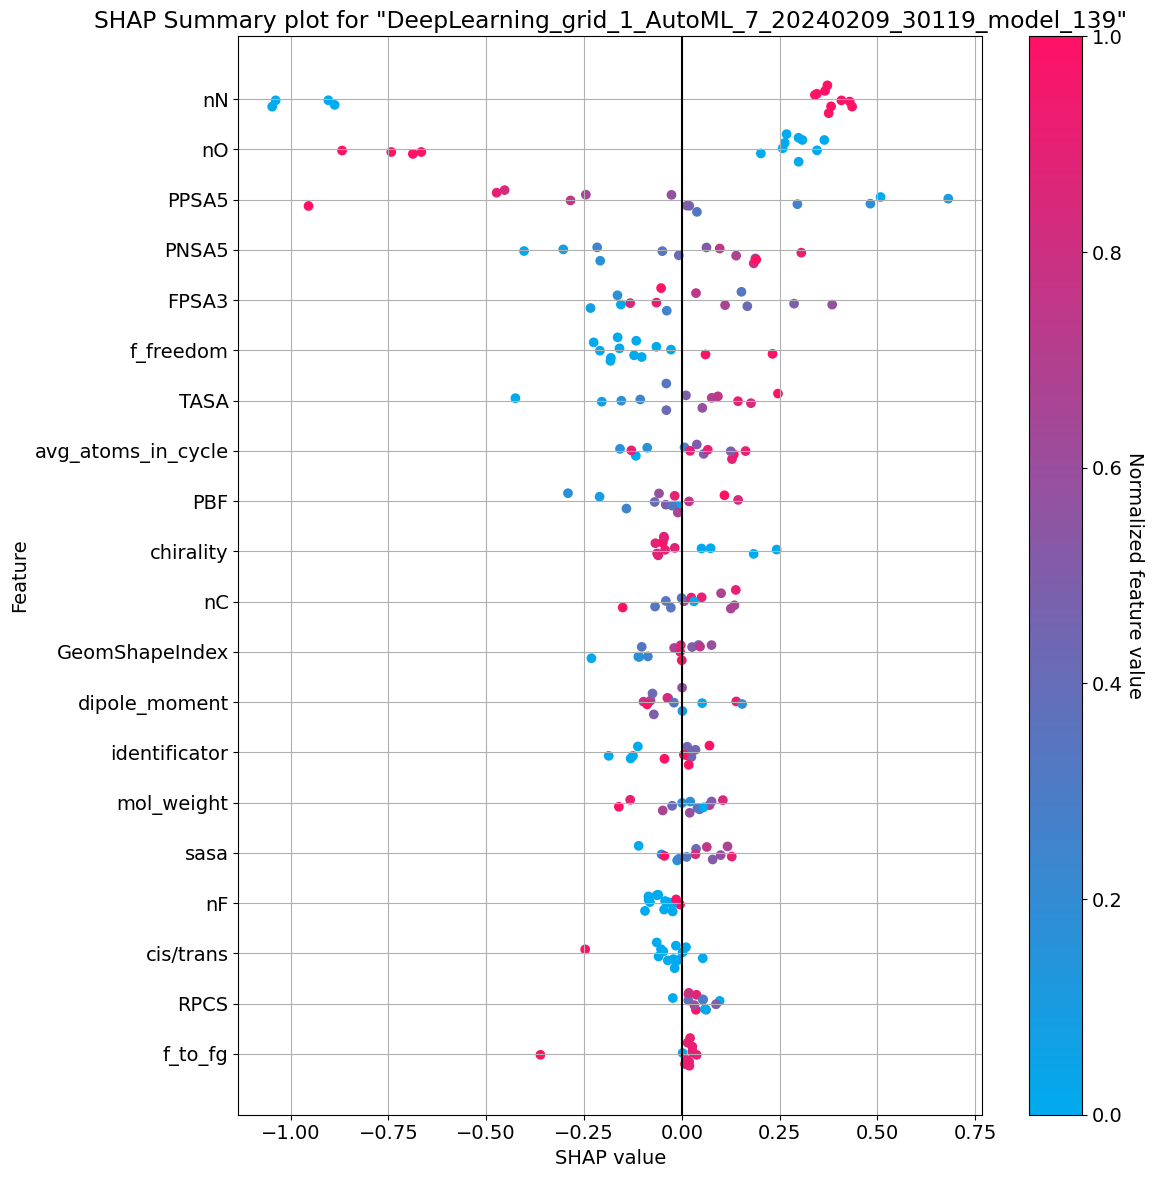

In [31]:
plt.rcParams.update({"font.size": 14})
shap_plot = best_model.shap_summary_plot(test, background_frame=train, samples=1000)

VAR IMPORTANCE

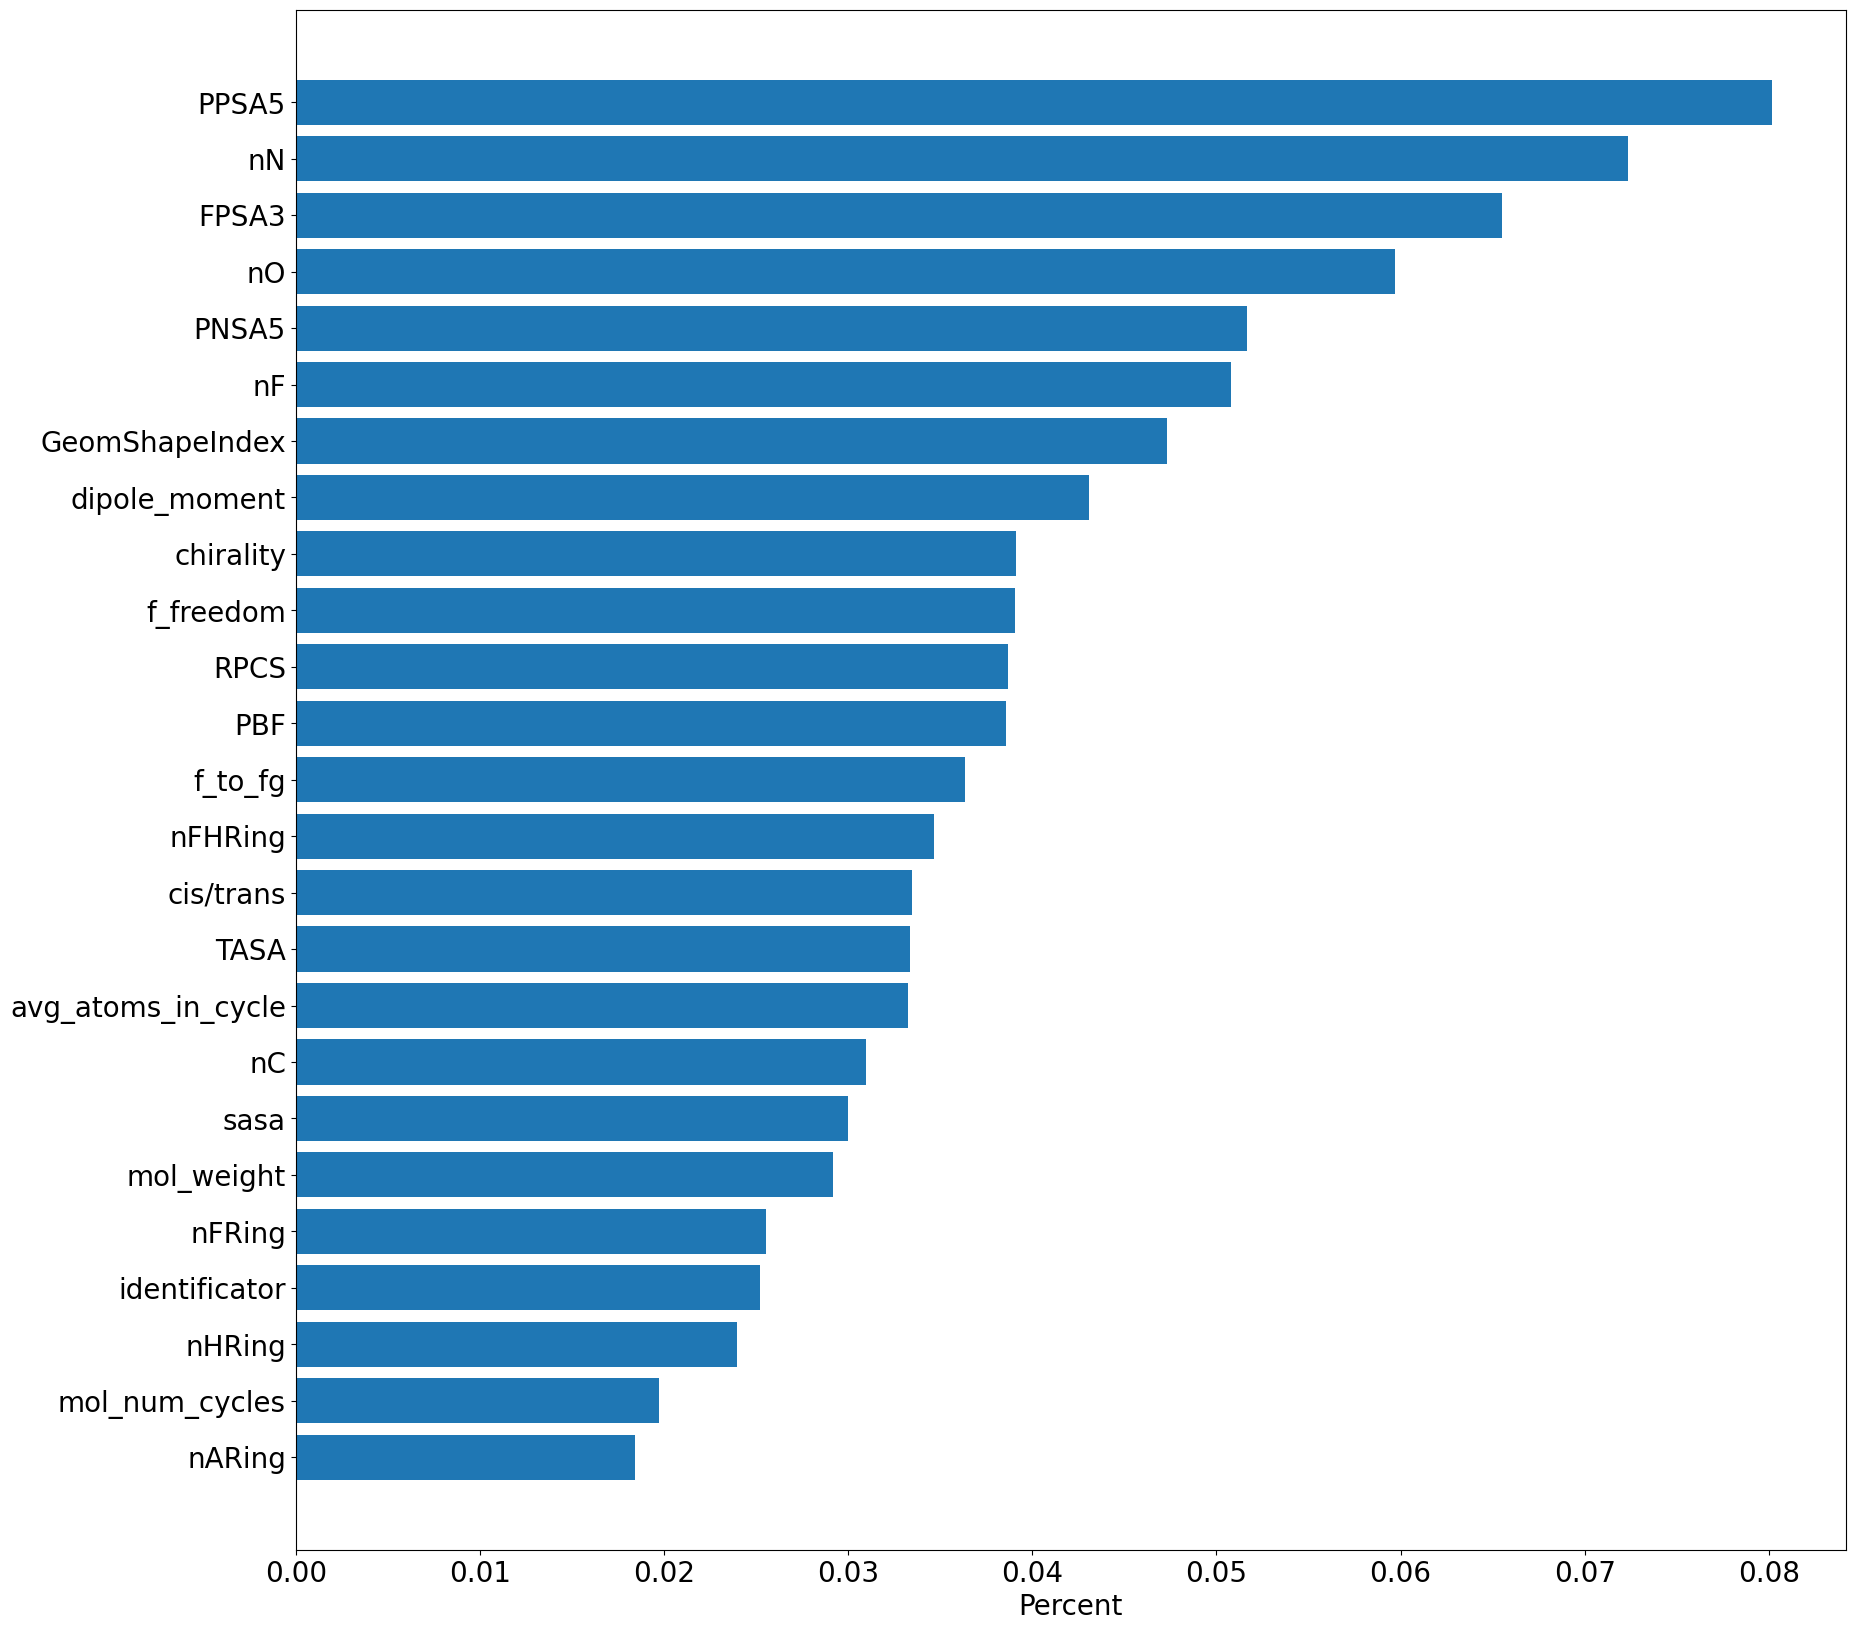

In [32]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

importance = best_model.varimp(test)

if importance is not None:
    fig, ax = plt.subplots(figsize=(20, 20))
    ax.barh(importance['variable'][:][::-1], importance['percentage'][:][::-1])
    ax.set_xlabel('Percent')


In [33]:
import os

MODEL_SAVE_PATH = r'C:\work\DrugDiscovery\main_git\XAI_Chem\ml_part\h2o_model\models\08.02.24_feature_2.2\pKa'

best_model = aml.get_best_model()

model_path = h2o.save_model(model=best_model, path=os.path.join(MODEL_SAVE_PATH, 'only_molecules_with_dihedral_angle(without_angle_feature)_without_outliers'), force=True)
model_path

'C:\\work\\DrugDiscovery\\main_git\\XAI_Chem\\ml_part\\h2o_model\\models\\08.02.24_feature_2.2\\pKa\\only_molecules_with_dihedral_angle(without_angle_feature)_without_outliers\\DeepLearning_grid_1_AutoML_7_20240209_30119_model_139'

----------

---------

---------------------

In [40]:
import os
import sys
sys.path.insert(0, os.path.dirname('C:\work\DrugDiscovery\main_git\XAI_Chem\ml_part'))

import pandas as pd

from ml_part.random_forest.data_prep.preparation import DataPreparation
from ml_part.random_forest.train import RFTrain

CSV_PATH = r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\remained_features_logP_08.02_v4_fixed_distances_chirality.csv'
smiles_filepath = r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\smiles_to_index.pkl'

dataPreparation = DataPreparation(CSV_PATH)

unimportant_features_to_drop = ['dipole_moment']
X, y = dataPreparation.prepare_data_for_RF(is_pKa=False,
                                           use_mandatory_features=True,
                                           is_remove_outliers=True,
                                           is_remove_nan=True,
                                           outliers_features_to_skip=unimportant_features_to_drop)

correlated_features = ['f_atom_fraction', 'naHRing', 'nFaRing', 'nFaHRing', 'tpsa+f']
ring_features_to_remain = ['nFRing', 'nHRing', 'nARing', 'nFHRing']
features_to_drop = []
for feature_name in X.columns:
    if feature_name in correlated_features:
        features_to_drop.append(feature_name)
    elif "ring" in feature_name.lower() and feature_name not in ring_features_to_remain:
        features_to_drop.append(feature_name)
    elif len(X[feature_name].unique()) == 1:
        print(f"feature without unique values: {feature_name}")
        features_to_drop.append(feature_name)
    elif "angle" in feature_name or "distance" in feature_name:
        features_to_drop.append(feature_name)

X = X.drop(features_to_drop, axis=1)

rf_train = RFTrain(X=X, 
                   y=y,
                   smiles_filepath=smiles_filepath,
                   is_pKa=False,
                   k_folds=2)

y_train = rf_train.y_train
X_train = rf_train.X_train

y_test = rf_train.y_test
X_test = rf_train.X_test

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

print(len(train_df), len(test_df))

train = h2o.H2OFrame(train_df)
test = h2o.H2OFrame(test_df)

True
183
['f_freedom', 'distance_between_atoms_in_cycle_and_f_group', 'PPSA5', 'mol_num_cycles', 'nFRing', 'nAHRing', 'angle_R1X1R2', 'nF', 'identificator', 'mol_weight', 'dipole_moment', 'nHRing', 'nO', 'PBF', 'nC', 'angle_X2X1R1', 'nARing', 'angle_R2X2R1', 'cis/trans', 'PNSA5', 'FPSA3', 'naRing', 'tpsa+f', 'mol_volume', 'RPCS', 'f_atom_fraction', 'GeomShapeIndex', 'WPSA5', 'TASA', 'f_to_fg', 'dihedral_angle', 'nFARing', 'distance_between_atoms_in_f_group_centers', 'avg_atoms_in_cycle', 'angle_X1X2R2', 'nFHRing', 'nFAHRing', 'chirality', 'pKa', 'logP']
mol_volume outliers indexes: [127]
f_atom_fraction outliers indexes: [124]
distance_between_atoms_in_f_group_centers outliers indexes: [ 35 167]
logP outliers indexes: [82, 83]
Remains rows:106, amount of features: 40
90 16


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [42]:
logP_model = h2o.load_model(r'C:\\work\\DrugDiscovery\\main_git\\XAI_Chem\\ml_part\\h2o_model\\models\\08.02.24_feature_2.2\\logP\\all_molecules(without_angle_feature)_without_outliers\\StackedEnsemble_BestOfFamily_3_AutoML_2_20240208_214951')

preds = logP_model.predict(test)
true = test.as_data_frame()['logP']
predicted_values = preds.as_data_frame()['predict']

calculate_metrics(true, predicted_values)

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


{'mse': 0.016, 'mae': 0.098, 'r^2': 0.929}